# Прогнозирование температуры расплава в печи-ковше

<div class="pull-right">

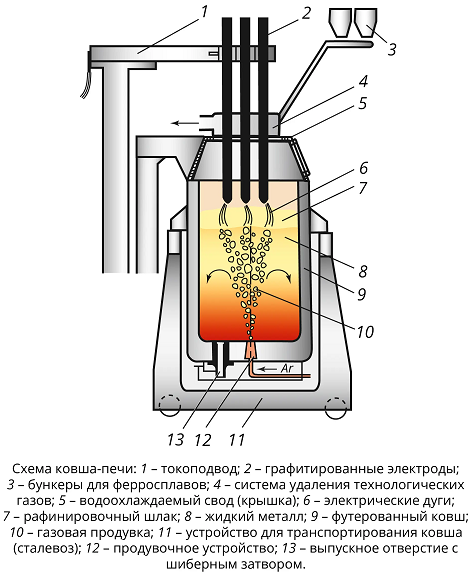

</div>

Чтобы оптимизировать производственные расходы, металлургическому комбинату необходимо уменьшить потребление электроэнергии на этапе обработки стали. Для этого комбинату требуется контролировать температуру сплава.\
Задача — построить модель, которая будет её предсказывать. Заказчик хочет использовать разработанную модель для имитации технологического процесса.\
Целевой признак, который необходимо предсказать - последняя температура партии (плавки). В модели допускается использование первой температуры и не допускается - промежуточных.

**Описание процесса обработки**

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены на крышке ковша.\
Сначала происходит десульфурация — из стали выводят серу и корректируют её химический состав добавлением примесей. Затем сталь легируют — добавляют в неё куски сплава из бункера для сыпучих материалов или порошковую проволоку через специальный трайб-аппарат.\
Прежде чем в первый раз ввести легирующие добавки, специалисты производят химический анализ стали и измеряют её температуру. Потом температуру на несколько минут повышают, уже после этого добавляют легирующие материалы и продувают сталь инертным газом, чтобы перемешать, а затем снова проводят измерения. Такой цикл повторяется до тех пор, пока не будут достигнуты нужный химический состав стали и оптимальная температура плавки.\
Дальше расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов.
<div>
    <font size="1.5", color = "grey">
        Изображение из Большой российской энциклопедии (https://bigenc.ru/c/kovsh-pech-0dd675)
    </font>
</div>

<div class="pull-right">
    
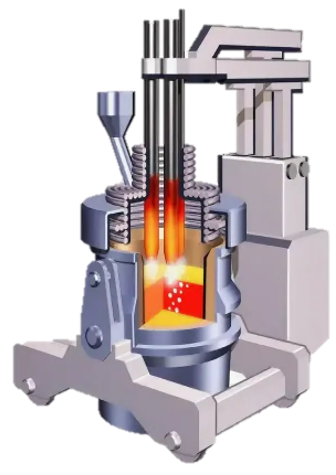
    
</div>

**Описание данных**

Данные хранятся в базе данных PostgreSQL.\
Она состоит из нескольких таблиц:\
`steel.data_arc` — данные об электродах;\
\-key — номер партии;\
\-BeginHeat — время начала нагрева;\
\-EndHeat — время окончания нагрева;\
\-ActivePower — значение активной мощности;\
\-ReactivePower — значение реактивной мощности.\
`steel.data_bulk` — данные об объёме сыпучих материалов;\
\-key — номер партии;\
\-Bulk1 … Bulk15 — объём подаваемого материала.\
`steel.data_bulk_time` — данные о времени подачи сыпучих материалов;\
\-key — номер партии;\
\-Bulk1 … Bulk15 — время подачи материала.\
`steel.data_gas` — данные о продувке сплава газом;\
\-key — номер партии;\
\-gas — объём подаваемого газа.\
`steel.data_temp` — данные об измерениях температуры;\
\-key — номер партии;\
\-MesaureTime — время замера;\
\-Temperature — значение температуры.\
`steel.data_wire` — данные об объёме проволочных материалов;\
\-key — номер партии;\
\-Wire1 … Wire15 — объём подаваемых проволочных материалов.\
`steel.data_wire_time` — данные о времени подачи проволочных материалов.\
\-key — номер партии;\
\-Wire1 … Wire15 — время подачи проволочных материалов.

Во всех файлах столбец key содержит номер партии. В таблицах может быть несколько строк с одинаковым значением key: они соответствуют разным итерациям обработки.
<div>
    <font size="1.5", color = "grey">
        Изображение с сайта https://metmash.kz/pech-kovsh/.
    </font>
</div>

## Exploratory data analysis

In [1]:
!pip install termcolor -q
!pip install shap -q

In [2]:
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
from pandas.plotting import table
import matplotlib.pyplot as plt
import seaborn as sns
from termcolor import colored, cprint
from ipywidgets import Output, HBox, Layout
import datetime
import seaborn as sns
from matplotlib.patches import Rectangle
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.dummy import DummyRegressor
from catboost import Pool, cv, CatBoostRegressor
import torch.nn as nn
import torch
from math import ceil
import shap
from tqdm import notebook

In [3]:
pd.set_option('display.max_columns', None)                                          # для вывода всех столбцов на экран

In [4]:
constant = 211223                                                                   # для random_state, seed

In [5]:
np.random.seed(constant)
torch.manual_seed(constant)

In [6]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') # для работы на GPU (при наличии)

Кастомные функции:

In [7]:
def table_info(df):
    '''выводит информацию о df: первые и последние 3 строки, общую информацию, кол-во полных дубликатов, 
    монотонность увеличения индексов, сумму и % пропусков'''
    output1 = Output()
    output1.layout.width = '600px'
    with output1:
        cprint ('Первые и последние 3 строки таблицы:', 'magenta', attrs=['bold'])
        display (pd.concat([df.head(3), df.tail(3)]))
                
        print (colored('\nКоличество полных строк-дубликатов: ','magenta', attrs=['bold']), 
               colored(str(df.duplicated().sum())))
        
        print (colored('\nИндексы монотонно увеличиваются: ','magenta', attrs=['bold']), 
               colored(str(df.index.is_monotonic_increasing)))

        cprint ('\nСумма и процент пропусков:', 'magenta', attrs=['bold'])
        isna_df = pd.concat([df.isna().sum(), df.isna().mean()*100],1).astype('int')
        isna_df.columns = ['sum', '%']
        display(isna_df.T)
        
    output2 = Output()
    with output2:
        cprint ('Общая информация о таблице:\n', 'magenta', attrs=['bold'])
        df.info()
        
    display(HBox([output1, output2], layout=Layout(justify_content='space-between')))

In [8]:
def description(feature, title=None, bins=100):
    '''По Series-признаку рисует диаграмму размаха, гистограмму и табличку с точными статистиками'''
    f, ax = plt.subplots(2,2, sharex=True, gridspec_kw={"height_ratios": (.15, .85), 
                                                        "width_ratios":  (0.85, 0.15)}, figsize=(9,3.5))
    sns.boxplot(x=feature, ax=ax[0,0])
    sns.histplot(x=feature, bins=bins, ax=ax[1,0], element="step", alpha=0.3)
    ax[0,1].remove()
    table(data=feature.describe().round(4), ax=ax[1,1], loc='right',colWidths=[1.8])
    
    ax[0,0].set(yticks=[], xlabel=None)
    sns.despine(ax=ax[1,0]); sns.despine(ax=ax[0,0], left=True)
    plt.axis('off'); f.suptitle(title)

In [9]:
def data_type(df):
    '''возвращает все существующие типы данных в df'''
    types = set()
    for col in df:
        types = types|set(df[col].apply(type).unique())
    return types

In [10]:
def minutes(t):
    '''возвращает кол-во минут с начала суток до времени t ('datetime.time')'''
    return t.hour*60+t.minute+t.second/60

In [11]:
def time_difference(start, end):
    '''возвращает интервал в минутах; на входе начало временного отрезка и конец в формате datetime.time'''
    if start>end:
        return 24*60 - minutes(start) + minutes(end)
    else:
        return minutes(end) - minutes(start)

In [12]:
def time_difference_max_min(row):
    '''возвращает интервал в минутах между макс. и мин. значениями времени (datetime.time); на входе Series'''
    only_time = [t for t in row if type(t)==datetime.time]
    return minutes(max(only_time)) - minutes(min(only_time))

In [13]:
def grid_result(grid):
    '''выводит топ-10 результатов перебора; на входе GridSearchCV или RandomizedSearchCV'''
    result = pd.DataFrame(grid.cv_results_).sort_values('rank_test_score')\
         [['rank_test_score','params','mean_test_score']].set_index('rank_test_score')[:10]
    result['mean_test_score']*=-1
    
    display (result)
    
    print (f"Минимальное MAE = {colored(grid.best_score_.round(3)*-1, 'cyan', attrs=['bold'])}\n\
    при гиперпараметрах {colored(grid.best_params_, 'cyan', attrs=['bold'])}.")

### Data load

In [14]:
db_config = {                                                            # конфигурация для подключения к базе данных
    'user': 'praktikum_student',
    'pwd': 'Sdf4$2;d-d30pp',
    'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
    'port': 6432,
    'db': 'data-science-final'
    }

In [15]:
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(                # строка с конфигурационными данными
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'])

In [16]:
engine = create_engine(connection_string)                                # создание соединения

In [17]:
# перечень всех таблиц в схеме steel
query = '''
SELECT tablename
FROM   pg_catalog.pg_tables
WHERE  pg_catalog.pg_tables.schemaname = 'steel'
'''

tables = pd.read_sql_query(query, con=engine).values[:,0]
tables

array(['data_arc', 'data_bulk', 'data_bulk_time', 'data_gas', 'data_temp',
       'data_wire', 'data_wire_time'], dtype=object)

Все 7 таблиц есть в наличии, как и указано в условии задачи.

In [18]:
for t in tables:                                                         # скачивание и трансформация всех 7-ми таблиц в df'мы
    exec(t+"=pd.read_sql_query('SELECT * FROM steel.'+t, con=engine)")

### data_arc

In [19]:
table_info(data_arc)

<div class="alert alert-info">

Скрин виджетов из функции table_info(). Результат не сохраняется. Необходимо запускать при открытии тетради.

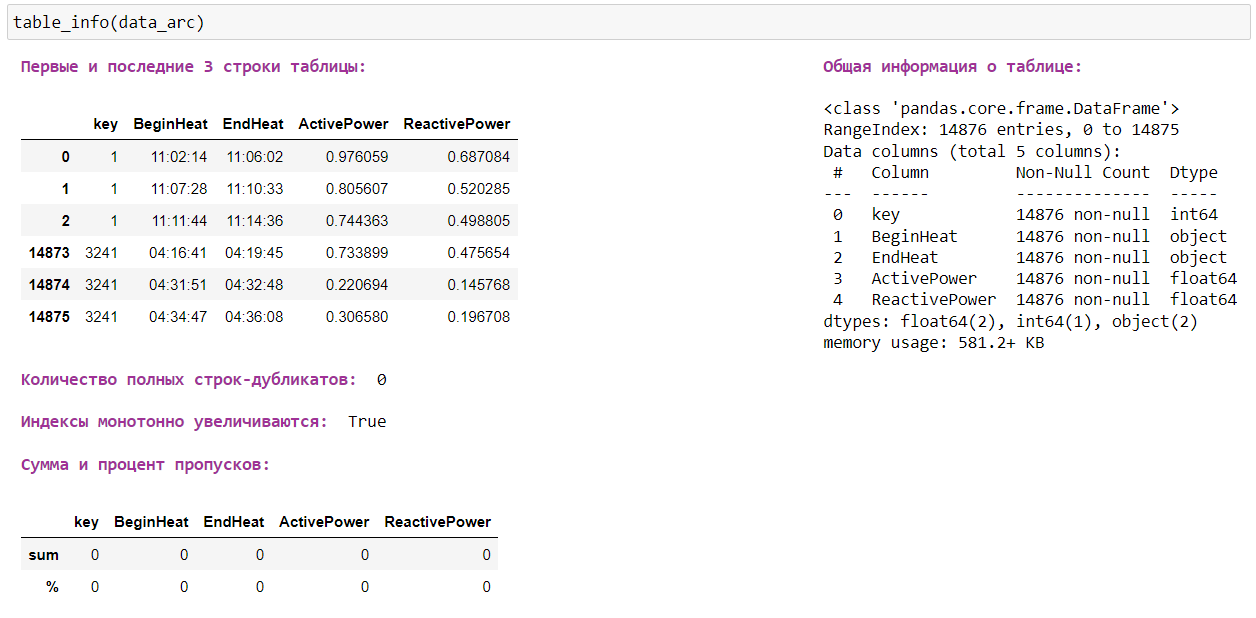
</div>

In [20]:
data_arc['key'].value_counts().to_frame(name='number_of_heats').T               # число периодов нагрева в определённой партии

,2108,1689,1513,2567,46,322,1829,2916,44,1958,638,2926,2917,1880,1014,2046,1866,1470,2631,45,274,2901,709,334,813,650,2564,1340,1574,280,2568,1041,1950,3120,2209,2859,1269,2342,2606,859,987,1651,2570,2562,935,1923,2366,460,1926,2376,692,2067,1515,3073,2804,2860,2618,1299,1203,131,2107,1921,2066,1881,2770,1181,2106,2858,808,1641,1453,531,163,2657,1890,1666,1236,235,2378,1426,1516,1290,1804,2277,180,164,475,2011,173,1052,708,496,2829,1915,405,2019,843,1478,2799,335,2105,2942,2902,2951,3239,2798,1366,2104,1120,2656,2265,663,2566,2416,2200,2344,2150,103,3198,2097,2511,993,1917,1432,1965,2151,1456,198,2287,2335,2439,231,2487,438,1720,435,297,2634,1752,803,547,1904,171,145,731,65,1600,1976,507,1512,1944,1560,691,2088,2698,2506,33,2530,1992,2714,2722,1409,329,2563,434,418,801,817,2435,2387,857,122,2131,2123,1001,1057,2001,1809,1065,1209,1529,482,2579,2018,2635,2002,425,2544,2576,2632,1401,1482,1330,3075,994,2995,2931,673,681,2736,769,642,2648,2941,2898,2964,1622,1550,3151,1094,2879,2855,718,694,598,462,2463,390,2359,2343,174,1933,1925,1653,1645,1581,1341,1309,1061,3100,1021,1710,1830,1886,815,1943,1903,1703,1663,1655,1399,3222,3190,3182,3118,959,759,1902,2806,727,687,583,2526,2510,2478,2438,2262,1966,1942,989,901,867,2932,2981,924,2965,1344,2861,652,2653,2565,2541,2477,2205,2141,2109,1931,1803,1755,1603,1571,1475,1467,1371,1123,3154,1051,2930,1028,3173,3181,2380,853,837,733,2780,2732,653,2636,2572,2556,2508,2452,2340,1460,2308,2260,149,2092,2068,1820,1668,1644,1524,1500,1492,1360,2047,1144,3169,2649,904,224,232,2641,2137,1216,576,3121,912,2321,240,2289,528,784,552,1184,64,2569,1328,2181,2061,2093,52,100,300,2165,2461,2027,2269,148,316,404,2317,2405,204,2381,2229,636,2761,1963,3122,2825,3162,3202,1163,3226,1187,1195,1291,1315,1323,1355,1363,1403,1435,1451,2501,2801,1507,1531,1811,420,572,2509,2721,1148,3213,1188,1196,1292,1396,1428,2633,1676,1724,1756,1788,1828,1892,1924,1932,1964,1996,2020,13,21,69,77,3189,1132,1100,684,672,2613,3010,580,2637,604,2661,660,2717,2725,2749,616,2781,844,852,2689,640,956,1004,3061,3069,3085,1019,2906,3002,2675,658,2755,2763,746,786,802,810,3017,826,834,842,2915,890,2947,3011,3019,1042,1066,1082,1122,3227,1202,1250,2691,2555,1362,498,1841,2033,10,2083,98,2155,138,146,154,2259,2267,2315,2323,346,354,370,2419,402,2451,450,466,2515,3041,1274,1410,915,2354,2402,2929,2514,880,2546,2913,864,2905,856,555,587,2642,611,651,707,2762,824,811,819,125,2922,875,792,315,291,1434,283,1530,1554,1570,1578,1642,1650,936,1698,1754,1802,1882,2074,43,2098,59,115,2170,2178,139,2202,2234,219,2290,117,2300,2204,79,95,168,2174,135,2246,223,263,271,311,144,327,2406,391,2169,2542,503,591,2646,2662,615,639,2710,2153,2142,1990,1046,1934,3119,3135,1118,3167,3175,1134,3183,3231,2281,1422,1438,1446,1454,216,2257,1638,1670,1678,1750,1758,1854,1870,1918,2718,671,2726,735,1231,1247,1335,1351,1359,1431,1439,1447,1503,1511,1575,1599,24,1687,1695,1711,1751,1759,1847,1855,1887,2057,1975,1223,1207,1183,2934,743,751,2814,783,791,2854,807,855,863,871,2950,1143,919,1007,3062,1023,3086,56,3126,3142,1119,1127,3111,1030,2212,2852,2892,448,861,869,877,2481,3012,3076,1029,2465,416,1101,3172,1157,1245,1333,1357,1405,1429,1461,1573,1637,1661,821,789,1022,2828,165,181,2236,1721,277,285,520,2404,373,381,2436,512,2516,2548,525,2612,581,589,2652,613,2700,2513,757,1677,1685,1717,1749,296,526,2575,574,582,2647,606,630,2687,654,2727,686,702,734,758,2815,790,814,878,2927,894,902,3055,518,446,312,118,1757,1813,1837,1949,1997,2013,2029,14,22,94,142,2431,150,2199,222,2279,254,262,270,2327,286,2385,1761,2049,2080,1569,809,1353,2288,553,2304,2584,1272,833,1816,2560,2912,1577,2944,1760,1192,2928,1728,1712,2936,1688,3225,1656,1609,1648,1128,1928,577,1377,97,73,2760,1121,3168,2704,649,641,25,1465,177,617,1097,193,3144,201,2808,1497,2000,1968,2264,1153,1256,1640,513,953,913,401,417,1400,2480,1257,2496,3072,3008,1624,1544,353,921,2152,1616,437,1716,2672,1780,2580,565,2664,1884,829,1900,456,1908,1916,2505,1940,805,2488,1948,441,2836,1972,1980,781,2012,481,2052,2060,585,1732,

Всего 3214 партий. Максимальное число циклов (периодов нагрева) 16, минимальное - 1.\
Большое число нагревов говорит о сложности получения стали в данной партии; пришлось много раз лигировать чтобы получить нужные свойства.

In [21]:
data_type(data_arc[['BeginHeat', 'EndHeat']])                                   # тип данных во временных столбцах

{datetime.time}

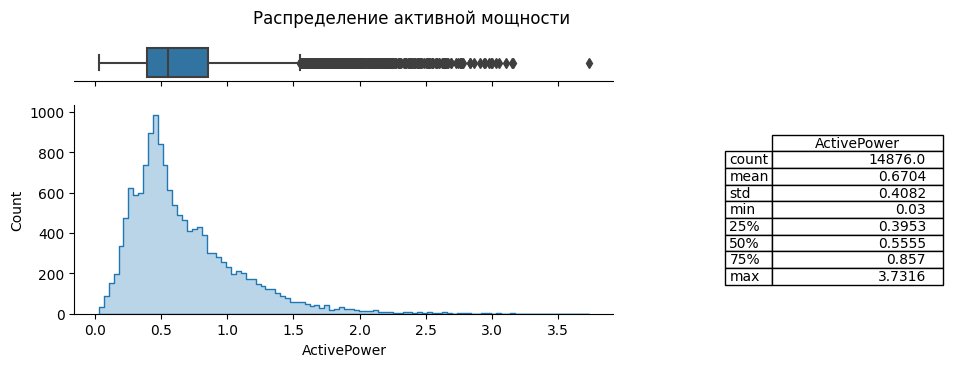

In [22]:
description(data_arc['ActivePower'], 'Распределение активной мощности')

In [23]:
data_arc.query('ActivePower>3.3')                                      # выброс в значении активной мощности

,key,BeginHeat,EndHeat,ActivePower,ReactivePower
7799,1689,18:49:03,19:04:10,3.731596,2.676388


In [24]:
data_arc.query('key==1689')                                             # все нагревы в партии с выбросом

,key,BeginHeat,EndHeat,ActivePower,ReactivePower
7793,1689,15:25:34,15:27:11,0.337803,0.242150
7794,1689,15:30:19,15:35:41,1.230050,0.809881
7795,1689,15:39:06,15:43:49,1.211215,0.852895
7796,1689,15:51:04,15:54:19,0.857824,0.559878
7797,1689,15:59:13,16:01:30,0.605553,0.394115
7798,1689,18:41:20,18:46:25,1.174942,0.997666
7799,1689,18:49:03,19:04:10,3.731596,2.676388
7800,1689,19:57:33,20:08:31,2.864100,2.150657
7801,1689,20:09:54,20:20:02,2.643099,1.823933
7802,1689,21:23:27,21:25:32,0.519904,0.397048


Выброс не намного отличается от основной массы значений. Допустимо ли такое значение и по какой причине оно могло возникнуть необходимо разбираться с технологом.\
Видим, что партия сложная из 15-ти циклов. Вероятно, это значение мощности могло быть и не будем удалять/корректировать.

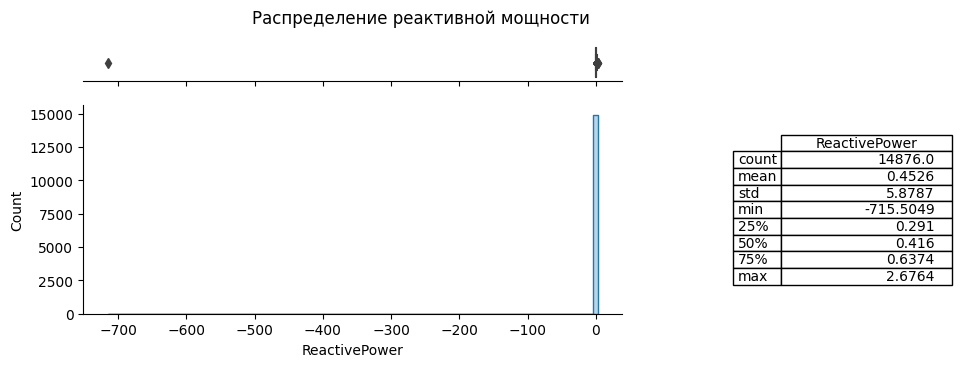

In [25]:
description(data_arc['ReactivePower'], 'Распределение реактивной мощности')

In [26]:
blowout_keys = data_arc.loc[data_arc['ReactivePower']<0, 'key']
blowout_keys

9781    2116
Name: key, dtype: int64

In [27]:
data_arc.query("key in @blowout_keys")                                         # все нагревы в партии с выбросом

,key,BeginHeat,EndHeat,ActivePower,ReactivePower
9779,2116,00:29:52,00:31:54,0.433266,0.306141
9780,2116,00:35:50,00:38:05,0.620265,0.408352
9781,2116,00:44:48,00:46:37,0.495782,-715.504924
9782,2116,00:51:51,00:52:58,0.299368,0.198796


Выброс явно аномальный. Удалим всю партию с подозрительным выбросом.

In [28]:
data_arc.drop(data_arc.query("key in @blowout_keys").index, inplace=True)

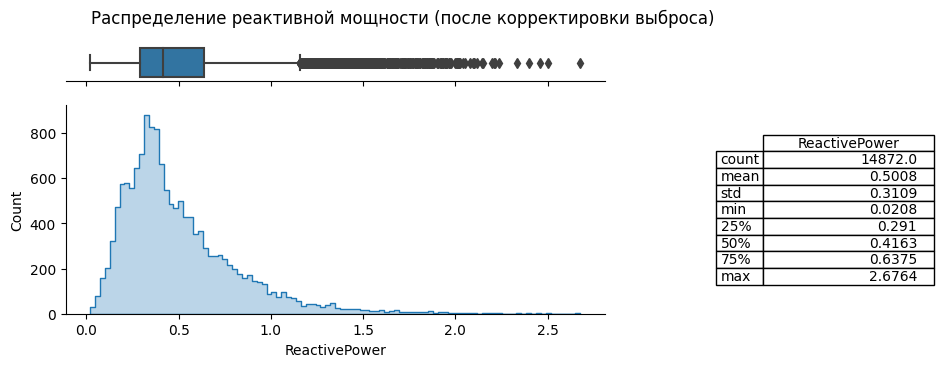

In [29]:
description(data_arc['ReactivePower'], 'Распределение реактивной мощности (после корректировки выброса)')

In [30]:
(data_arc.ActivePower.median()/data_arc.ReactivePower.median()).round(2) # во сколько раз активная мощность больше реактивной

1.33

Значения мощностей и их распределения схожи - носят нормальный характер.

Полная мощность определяется по формуле:
$S=\sqrt{P^2+Q^2}$, где P - активная мощность, Q - реактивная.\
Подставим медианные значения мощностей из задачи в формулу для определения полной мощности:\
$S=\sqrt{0.6^2+0.4^2}=0.72$\
Номинальная мощность печного трансформатора для 100-тонного агрегата порядка 18 МВ·А.\
В каких единицах измерения даны мощности в задаче неясно. Подразумеваем, что предоставлены как-то отмасштабированные значения.

Реактивная мощность является негативным понятием электротехнической системы и характеризует величину неиспользованной энергии из-за реактивных элементов приёмника (индуктивности, конденсаторы, обмотки двигателей).\
Вклад в разогрев расплава вносит только активная мощность.\
Для построения ML-модели реактивную мощность учитывать не будем.

In [31]:
data_arc[data_arc['BeginHeat']==data_arc['EndHeat']].shape[0] # число нагревов, где время начала нагрева равно времени конца

0

In [32]:
data_arc[data_arc['BeginHeat']> data_arc['EndHeat']].shape[0] # число нагревов, где время начала нагрева больше времени конца

22

In [33]:
data_arc[data_arc['BeginHeat']>data_arc['EndHeat']].sample(5) # случайные 5 строк с аномальным временем

,key,BeginHeat,EndHeat,ActivePower,ReactivePower
9513,2063,23:58:36,00:00:41,0.566324,0.379927
4752,1026,23:59:04,00:07:07,1.680239,1.400063
6986,1515,23:58:56,00:02:11,0.756416,0.500854
1953,421,23:58:33,00:01:57,0.774585,0.583186
7864,1702,23:58:32,00:00:14,0.430305,0.310953


ВременнЫе столбцы не содержат дату. Поэтому случаи с более высоким начальным временем означают, что замер начинался в предыдущие сутки. 

In [34]:
data_arc['time_heat'] = data_arc.apply(lambda x: time_difference(x['BeginHeat'],x['EndHeat']), 1) # время нагрева, мин.
data_arc['time_heat'].describe()

count    14872.000000
mean         2.861467
std          1.636560
min          0.183333
25%          1.783333
50%          2.450000
75%          3.566667
max         15.116667
Name: time_heat, dtype: float64

In [35]:
data_arc['energy'] = data_arc['ActivePower']*data_arc['time_heat']                     # энергия, потраченная на нагрев

In [36]:
# сводная таблица с общим количеством энергии, потраченной за партию, и числом циклов (нагревов) в партии
data_arc_pivot = data_arc.pivot_table(index='key', values='energy', aggfunc=['sum','count'])
data_arc_pivot.columns = ['energy', 'count']
display (data_arc_pivot.head(3)); print('Размер: ', data_arc_pivot.shape)

,energy,count
key,,
1,20.130071,5
2,12.230275,4
3,7.393055,5


Размер:  (3213, 2)


### data_bulk

In [37]:
table_info(data_bulk)

<div class="alert alert-info">

Скрин виджетов из функции table_info(). Результат не сохраняется. Необходимо запускать при открытии тетради.

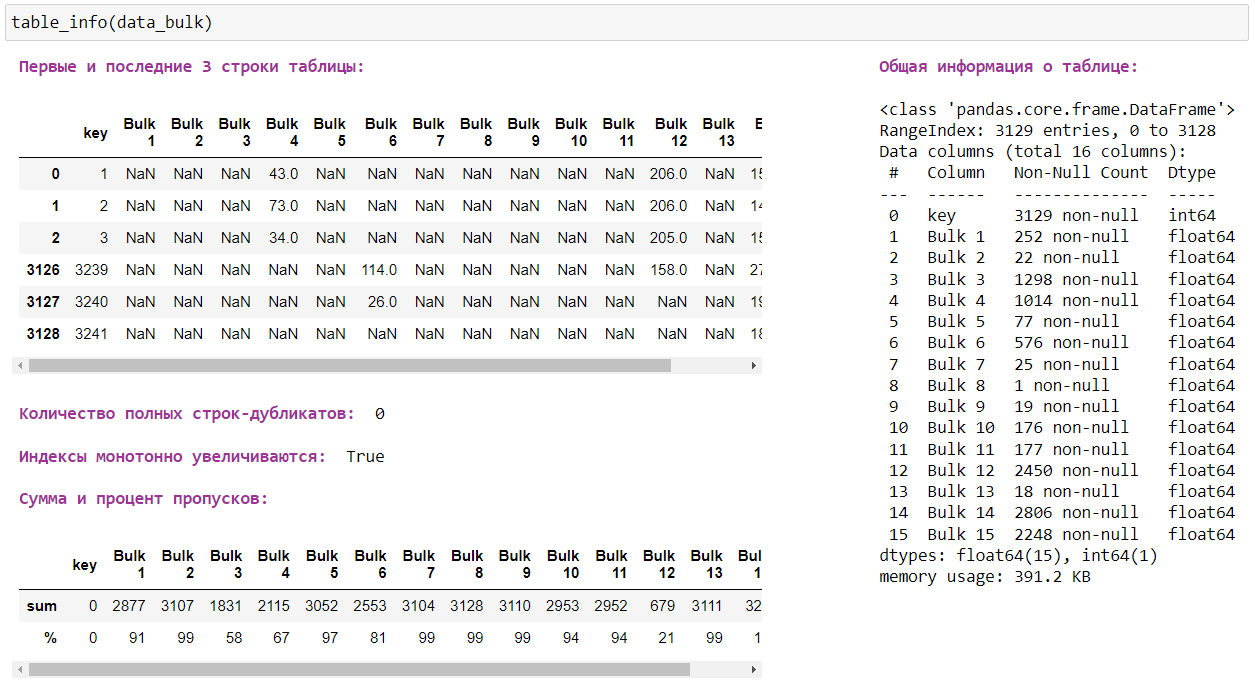
</div>

In [38]:
data_bulk['key'].nunique()                                        # кол-во упомянутых партий в таблице

3129

Каждой строке соответсвует отдельная партия.\
Каждому столбцу соответсвует определённый сыпучий материал (15 видов).

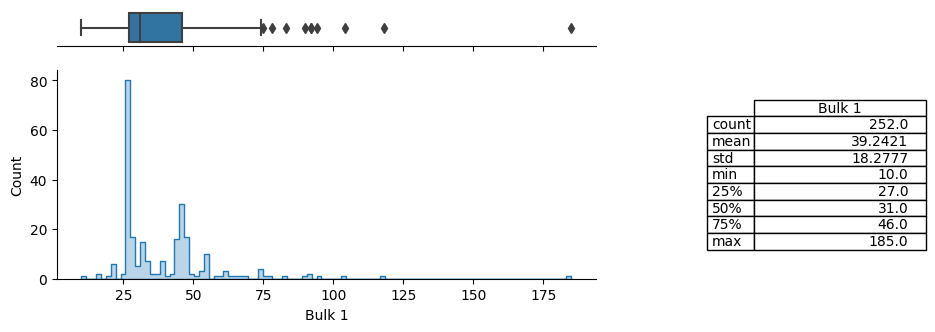

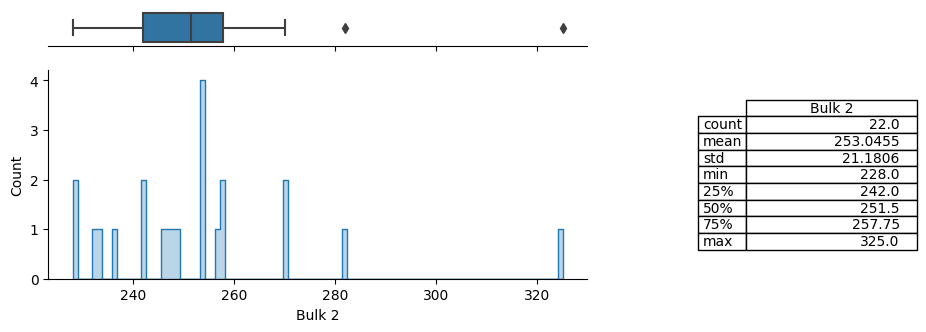

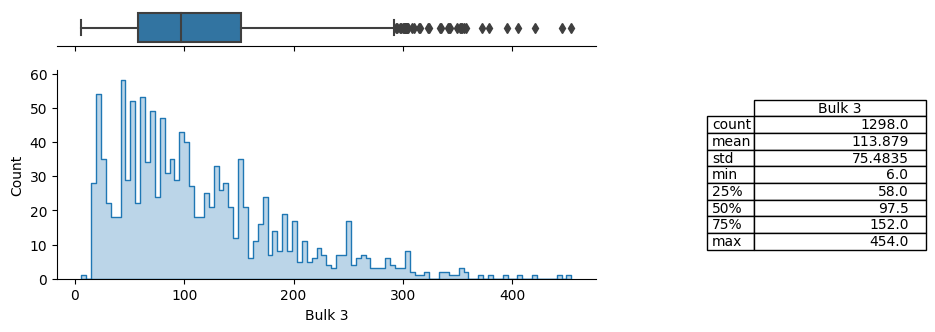

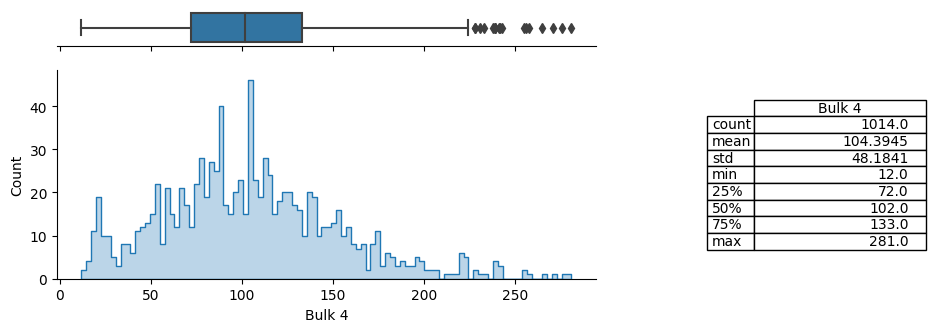

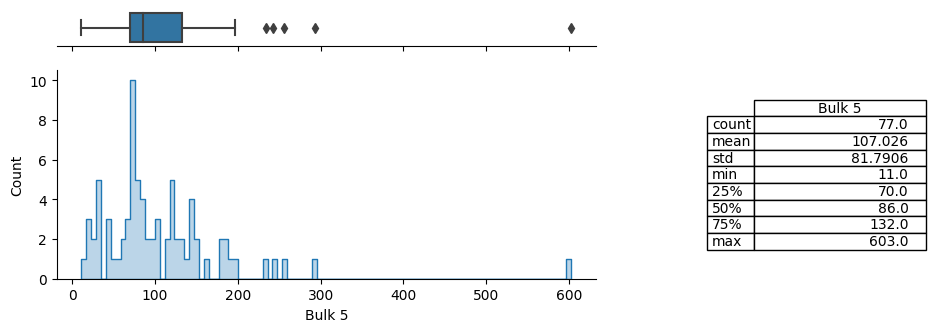

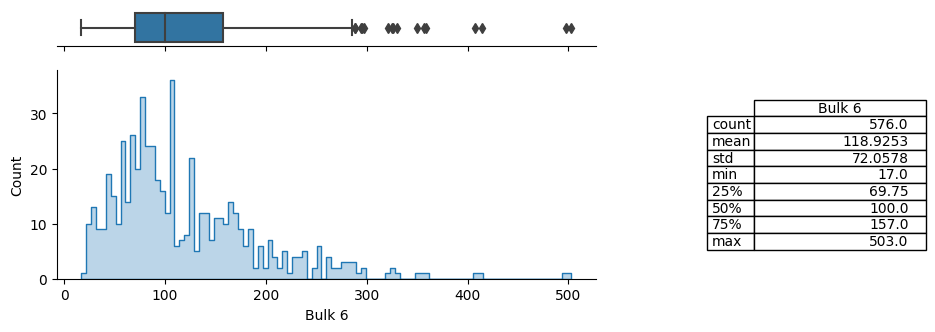

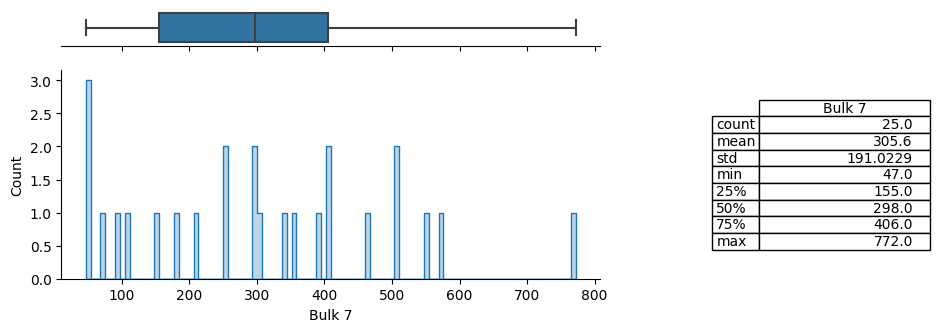

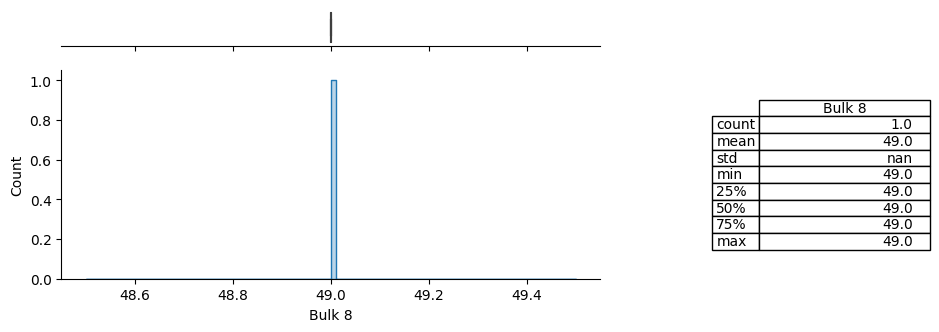

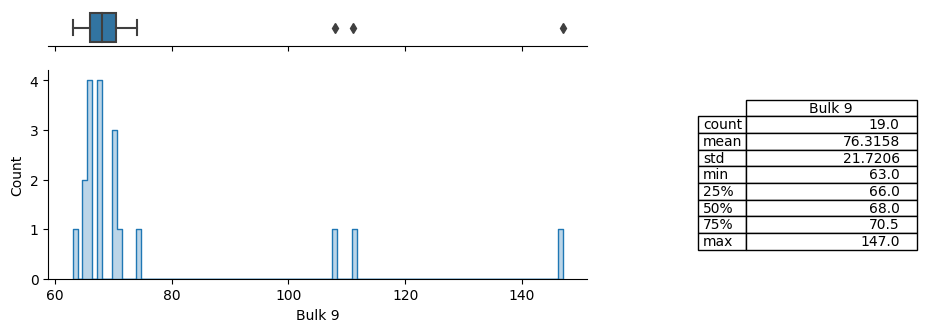

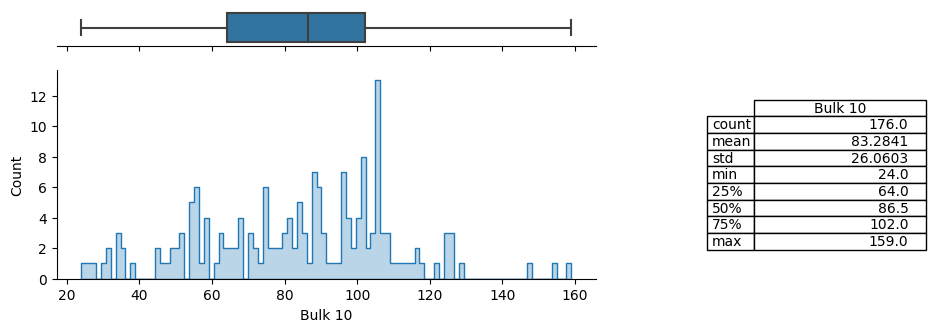

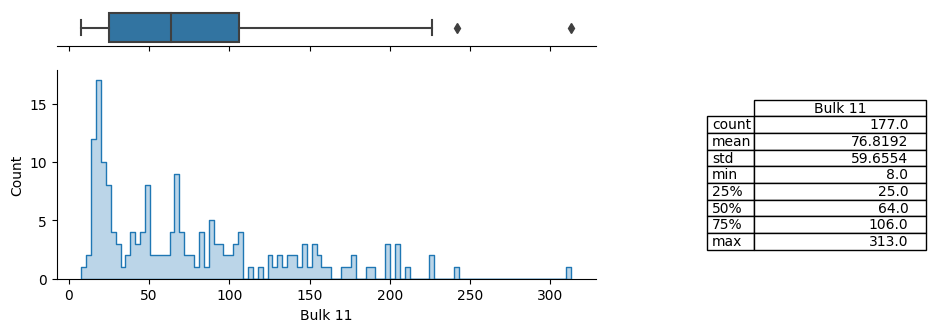

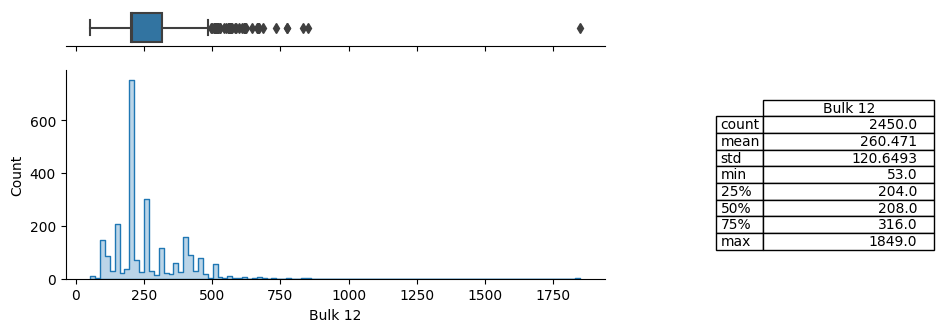

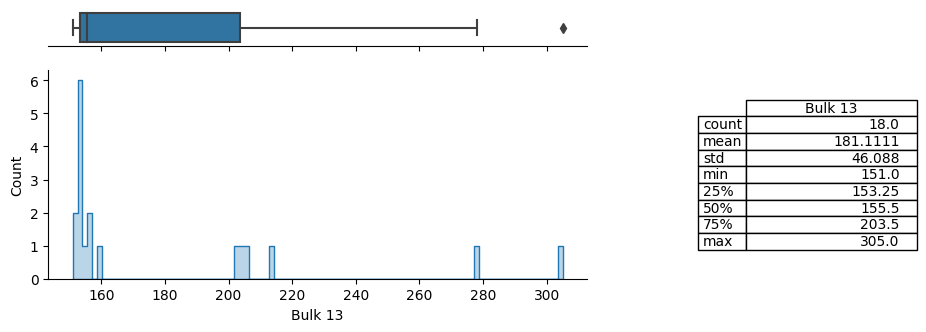

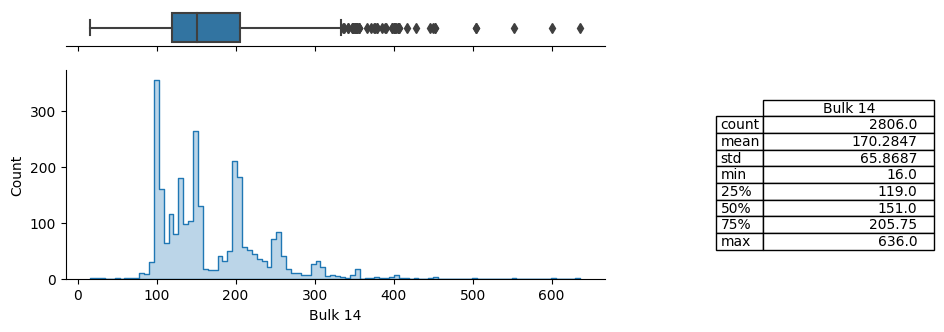

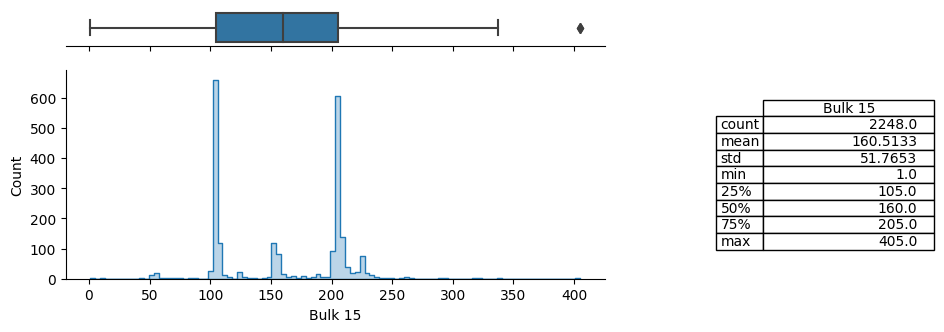

In [39]:
for col in data_bulk.columns[1:]:                                 # распределение каждого из 15-ти видов сыпучего материала
    description(data_bulk[col])


Явных и однозначных выбросов/аномалий нет. Указанные количества вполне могли применяться в качестве присадок.

In [40]:
data_bulk.fillna(0, inplace=True)                                                     # заполняем пропуски нулями
data_bulk.set_index('key', inplace=True)                                              # в качестве индекса устанавливаем партию
display(data_bulk.head(3)); print('Размер: ', data_bulk.shape)

,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
key,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0


Размер:  (3129, 15)


### data_bulk_time

In [41]:
table_info(data_bulk_time)

<div class="alert alert-info">

Скрин виджетов из функции table_info(). Результат не сохраняется. Необходимо запускать при открытии тетради.

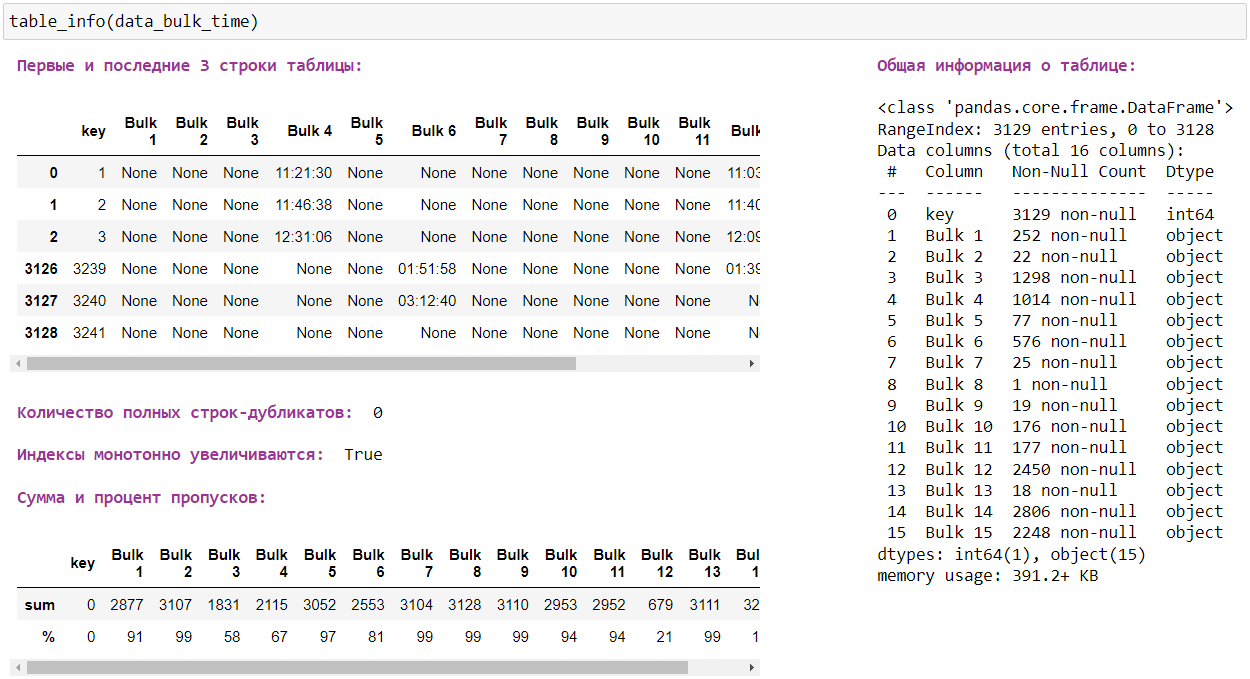
</div>

In [42]:
data_bulk_time['key'].nunique()                                                 # кол-во упомянутых партий в таблице

3129

Каждой строке соответсвует отдельная партия.\
Каждому столбцу соответсвует определённый сыпучий материал (15 видов).

In [43]:
data_type(data_bulk_time.iloc[:,1:])                                            # тип данных во временнЫх столбцах

{NoneType, datetime.time}

Проверим заполнена ли ячейка в таблице времени, если заполнена соответствующая ячейка в таблице объёма (и наоборот).\
Предварительно необходимо проверить, что "системы координат" в таблицах идентичны. То есть, наименования материалов и партий должны быть отсортированы идентично.

In [44]:
data_bulk.index.is_monotonic_increasing                       # монотонный рост номеров партий в таблице с объёмами материалов

True

In [45]:
data_bulk_time.set_index('key', inplace=True)                                        # в качестве индекса устанавливаем партию
data_bulk_time.index.is_monotonic_increasing            # монотонный рост номеров партий в таблице с временем подачи материала

False

In [46]:
data_bulk_time.sort_index(inplace=True)                        # сортировка по номеру партии в таблице с временем

In [47]:
# количество несоответсвий ячеек в двух таблицах по каждому типу сыпучих материалов
((data_bulk.isna()|data_bulk==0) != data_bulk_time.isna()).sum().to_frame('count').T

,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Ячейки в таблицах `data_bulk` и `data_bulk_time` соответсвуют друг другу.

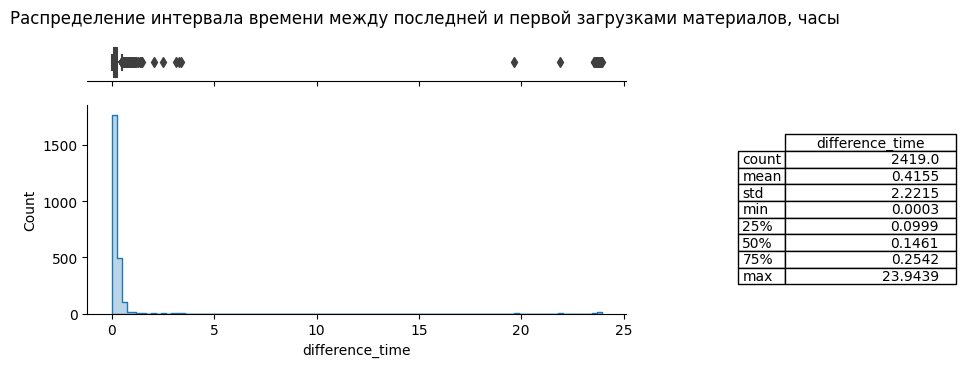

In [48]:
data_bulk_time['difference_time'] = data_bulk_time.apply(lambda x: time_difference_max_min(x)/60, 1)
description(data_bulk_time['difference_time'][data_bulk_time['difference_time']!=0], 
            'Распределение интервала времени между последней и первой загрузками материалов, часы')

<a id= 'bulk_time'></a>Во временнЫх признаках нет информации о дате, только время. Соответсвенно партия могла начаться, например, поздно вечером после 23:00 и закончиться в 2 ночи на следующие сутки. Без учёта даты интервал между максимальным и минимальным значениями времени будет 21 час.\
Таким образом на графике видим, где выбросы более 19 часов означают, что, скорее всего, плавка заняла до 4 часов (например, с 21 до 00).\
Аномалий в данных нет.

### data_gas

In [49]:
table_info(data_gas)

<div class="alert alert-info">

Скрин виджетов из функции table_info(). Результат не сохраняется. Необходимо запускать при открытии тетради.

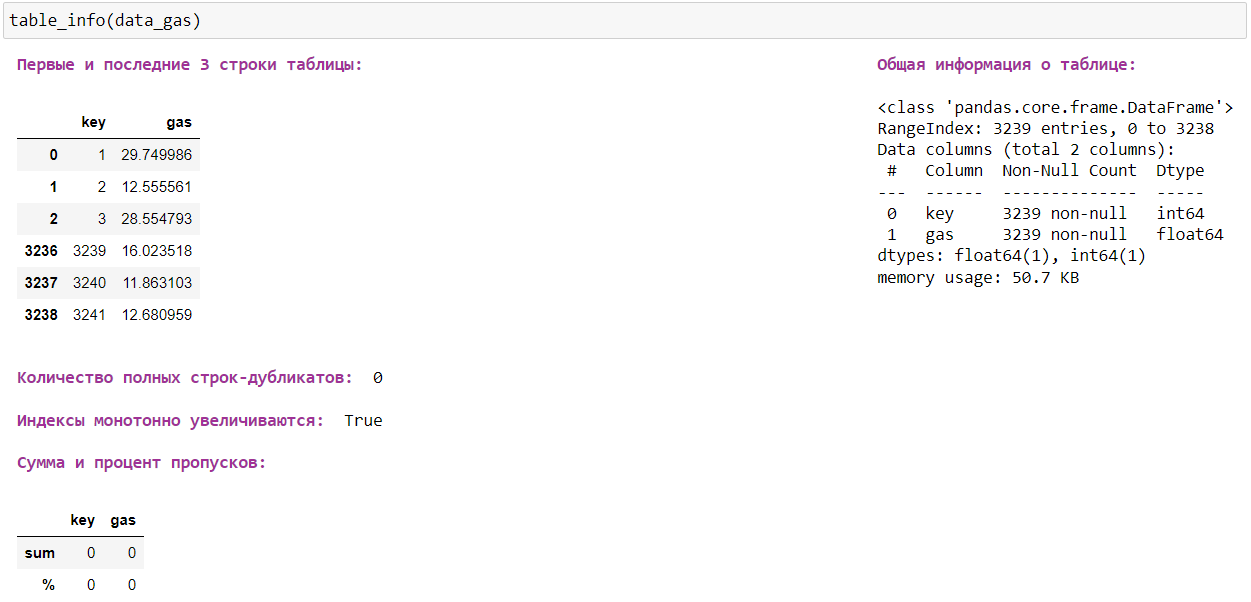
</div>

In [50]:
data_gas['key'].nunique()                                                 # кол-во упомянутых партий в таблице

3239

Каждой партии соответсвует отдельная строка.

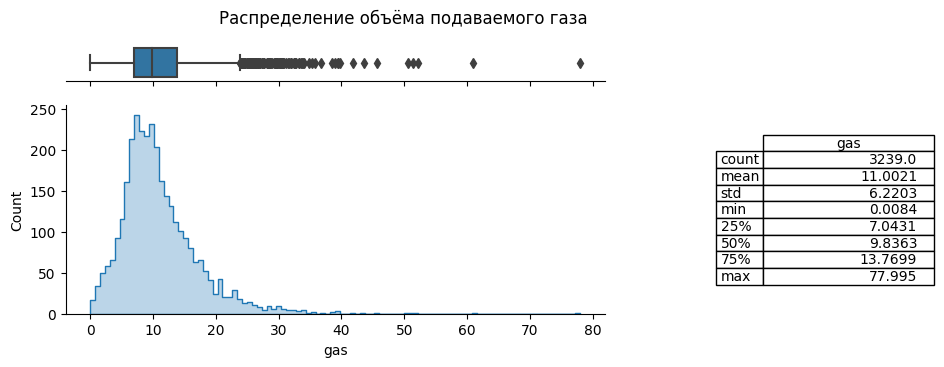

In [51]:
description(data_gas['gas'], 'Распределение объёма подаваемого газа')

Обнаруженные выбросы допустимы. Аномалий не обнаружено.

In [52]:
data_gas.set_index('key', inplace=True)                                              # в качестве индекса устанавливаем партию
display(data_gas.head(3)); print('Размер: ', data_gas.shape)

,gas
key,
1,29.749986
2,12.555561
3,28.554793


Размер:  (3239, 1)


### data_temp

In [53]:
table_info(data_temp)

<div class="alert alert-info">

Скрин виджетов из функции table_info(). Результат не сохраняется. Необходимо запускать при открытии тетради.

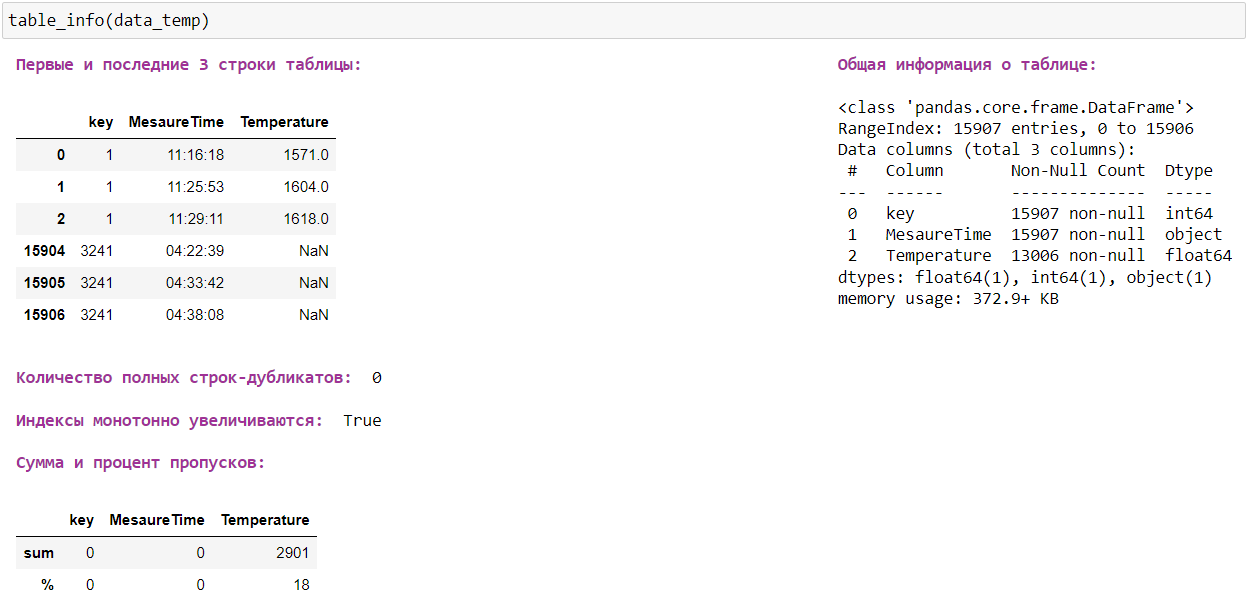
</div>

In [54]:
data_temp['key'].is_monotonic_increasing                                      # номера партий в таблице монотонно увеличиваются

True

In [55]:
data_temp['key'].value_counts().to_frame(name='number_of_measurements').T               # число замеров Т в определённой партии

,46,1214,1513,44,1689,2108,877,1051,2770,2567,1078,2916,901,45,935,240,735,2332,457,174,2564,1818,628,56,1492,2926,1340,198,2068,2410,2391,75,2106,2829,2562,176,959,2107,1470,322,33,2563,1934,1614,2684,1755,2850,235,1229,1269,225,1405,219,2565,117,3172,1687,1821,1992,1917,660,237,2406,1880,2799,2011,103,2855,626,2570,168,1203,115,2785,1187,2166,1942,1926,1243,417,1033,118,2438,1001,904,2290,335,2366,2367,2109,2341,2110,2936,231,446,2858,1958,1870,3080,2019,1820,2732,1688,709,1697,2321,104,2804,2971,57,21,1596,2836,1143,813,3134,650,2830,1916,138,2556,2404,2901,1650,2742,1653,1855,3077,1912,1915,2860,2020,97,389,429,3111,49,1907,1371,3239,53,2268,25,1315,2720,621,1515,1014,1651,764,869,2653,3073,2351,2517,1156,2525,1148,1605,1216,2687,2360,329,1933,1366,30,780,748,2375,1517,1333,252,912,638,2797,3012,2200,2639,2631,625,180,1524,2229,1516,1181,2277,1205,2917,841,397,482,375,131,319,311,303,3030,496,3240,2859,802,1881,1087,2250,3216,135,2150,95,2354,87,1257,2162,91,1866,2806,759,1529,1658,1682,2361,1754,2654,1194,1817,1066,2582,871,19,1353,3011,2289,59,498,1562,1550,1351,48,1655,875,3008,1543,2123,74,555,3112,1399,2649,234,1686,2506,2946,2179,2483,10,450,194,2944,1362,1729,193,3075,1761,1460,1380,106,1290,258,1904,249,1276,2187,1298,2163,1228,1976,1426,2104,314,298,2164,2001,554,2643,18,170,2475,418,1514,762,2064,113,818,2131,1788,1756,125,165,181,1708,2915,2579,2931,189,1809,642,2912,1028,3144,2714,3096,1923,12,28,507,459,2490,2656,52,60,2688,1121,108,2394,2378,2722,1803,843,1611,3154,3114,913,931,1299,1323,801,2930,2922,2832,769,1483,1499,1507,2906,164,2346,3053,353,2821,2050,2002,1978,2837,2416,1139,844,2632,345,1890,1802,2949,924,3013,980,2066,2765,716,708,2405,2461,428,2234,2568,513,505,2202,497,460,139,1273,2480,2725,1305,2861,13,405,3151,454,2511,920,2727,758,2847,856,2887,848,1110,1224,2817,1398,1438,2793,1446,728,1486,1526,1830,2471,2439,992,390,1837,1853,1909,1965,1981,3201,2013,3169,2111,70,102,2151,1088,126,2199,166,2295,270,3057,664,1878,1902,2401,783,791,2846,2854,2902,2934,232,224,3142,2209,1223,128,1247,1551,1815,1839,32,1951,2057,352,615,1950,2622,624,1982,2657,2641,2633,576,79,552,512,255,2537,2398,2414,2489,2502,2473,2526,2566,2606,1192,162,3100,1021,1213,2820,3052,773,461,1237,2780,1301,2828,1760,701,2508,1592,733,861,2484,1581,1840,519,2574,727,1482,2026,1442,2034,2542,2124,1530,487,43,2098,69,1434,2510,2598,1898,1906,2708,693,639,1698,663,1762,2718,591,101,67,1850,567,1882,1642,2766,1538,1084,2796,455,443,2142,37,2118,2094,2466,419,435,39,789,2322,23,821,2514,2538,15,2062,2060,2046,2092,111,2788,147,2146,447,2478,1410,423,123,2812,765,163,175,2218,171,179,2294,2242,239,203,2230,141,1250,2212,1330,346,2395,370,386,2435,1327,2467,1287,1239,1231,2308,2507,466,2524,2539,1207,1199,1175,1167,1335,338,1439,2299,186,2468,202,210,1999,1975,218,1887,1847,1503,2315,2492,274,290,357,306,1751,1511,546,3166,2635,3203,2950,3067,2942,3091,863,1122,2910,1138,2692,2947,839,815,1218,1234,547,173,645,1306,903,2958,3150,2803,229,2675,533,1079,2715,682,2739,2747,3126,613,3118,778,1055,3086,3022,850,2990,2660,531,1966,853,2455,398,276,1093,2397,356,1468,364,2421,2437,404,2431,334,1396,2477,2359,2485,2343,452,2335,236,2463,2027,228,686,2061,2069,1540,2719,2093,630,622,2647,598,2623,2165,140,148,470,1500,3108,196,2269,2509,286,476,1221,2063,796,14,804,3205,2005,1525,1997,1140,2925,3173,3157,1108,1100,1829,1789,3037,1092,1685,788,22,1421,2685,2533,492,1356,2287,2613,572,214,2215,2693,3213,1292,1309,1236,1373,94,2135,86,1180,702,734,1988,1766,867,1662,1638,1622,891,2948,1844,939,1478,2994,3002,955,3010,1828,987,1454,995,2956,1804,1710,1806,2003,819,2618,2634,1637,1980,603,611,619,2674,1918,667,1932,691,707,2762,2932,2818,771,1854,1892,3138,2972,925,3162,2951,2919,846,1547,1579,1684,1668,1683,1005,814,1827,1851,1899,1572,2823,1564,1939,1963,1971,998,3055,1419,1259,3170,2452,3218,1262,941,1230,1219,3183,3167,1411,1307,1692,1094,1355,1363,1054,1403,3079,1350,2049,777,1144,897,704,2056,2560,336,2385,1800,216,1977,2344,2528,1120,1816,297,2

Всего 3216 партий (в `data_arc` - 3214). Максимальное число замеров - 16, минимальное - 1.

In [56]:
data_type(data_temp[['MesaureTime']])                                # тип данных во временнОм столбце

{datetime.time}

Заказчик предупредил, что значения температуры ниже 1500 градусов — аномальные. Т плавления стали: [1450 - 1520 °С](https://ru.wikipedia.org/wiki/%D0%A1%D1%82%D0%B0%D0%BB%D1%8C#:~:text=%D0%A2%D0%B5%D0%BC%D0%BF%D0%B5%D1%80%D0%B0%D1%82%D1%83%D1%80%D0%B0%20%D0%BF%D0%BB%D0%B0%D0%B2%D0%BB%D0%B5%D0%BD%D0%B8%D1%8F%3A-,1450%E2%80%941520,-%C2%B0C.).

In [57]:
data_temp.query('Temperature<1500').shape[0]          # число строк (замеров) с аномально низкой температурой

7

In [58]:
# партии с числом замеров, среди которых есть аномальные значения
anomalous_keys = data_temp.query("key in @data_temp.query('Temperature<1500')['key']").\
                           groupby('key')['key'].count()
anomalous_keys

key
867      6
1214    16
1619     5
1818    12
2052     5
2561     6
Name: key, dtype: int64

In [59]:
anomalous_keys.shape[0]                                                             # число партий подлежащих удалению

6

In [60]:
anomalous_keys.sum()                                                                # число строк подлежащих удалению

50

In [61]:
data_temp.drop(data_temp.query('key in @anomalous_keys.index').index, inplace=True) # удаление аномальных партий

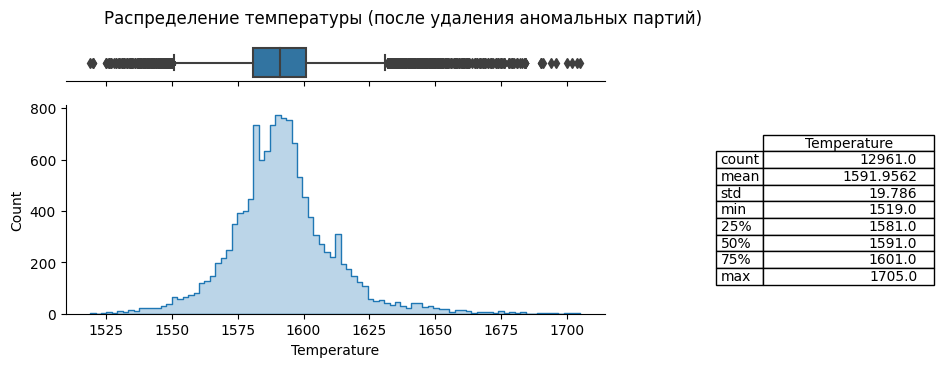

In [62]:
description(data_temp['Temperature'], 'Распределение температуры (после удаления аномальных партий)', bins=90)

Согласно условию задачи возможно использовать ключи, у которых как минимум два наблюдения: первый и последний замеры температуры.

In [63]:
data_temp.drop(data_temp.query('key in (195,279)').index, inplace=True)               # удаление партий с одним замером Т

In [64]:
# первое и последнее время в каждой партии
temp_first_last = data_temp.groupby('key')['MesaureTime'].agg([('time_min', lambda s: s[s.index.min()]),
                                                               ('time_max', lambda s: s[s.index.max()])])
display(temp_first_last.head(3)); print('Размер: ', temp_first_last.shape)

,time_min,time_max
key,,
1,11:16:18,11:30:39
2,11:37:27,11:59:12
3,12:13:17,12:34:57


Размер:  (3208, 2)


In [65]:
def temperature(s):
    '''возвращает Т по номеру партии и времени замера; на входе Series из одной позиции (time min/max) с именем (key)'''
    return data_temp[(data_temp['key']         == s.name) & 
                     (data_temp['MesaureTime'] == s.values.item())]["Temperature"].values.item()

temp_first_last['T_first'] = temp_first_last[['time_min']].apply(temperature, 1) # Т во время 1-ого замера в партии
temp_first_last['T_last']  = temp_first_last[['time_max']].apply(temperature, 1) # Т во время последнего замера в партии

В исходной `data_temp` в `MesaureTime` пропусков не было. Следовательно в сводной `temp_first_last` нет пропущенных строк (партий).\
Но могут быть пропуски в столбцах с температурой. Для ML необходимы оба значения - первое (признак) и последнее (целевой признак).

In [66]:
temp_first_last.isna().sum()

time_min      0
time_max      0
T_first       0
T_last      738
dtype: int64

Большое число пропусков - 23%.

In [67]:
data_temp.query("key in @temp_first_last.query('T_last.isna()').index").head(20)  # партии с пропуском Т на последнем замере

,key,MesaureTime,Temperature
12267,2500,03:11:31,1539.0
12268,2500,03:24:43,NaN
12269,2500,03:25:16,NaN
12270,2500,03:28:21,NaN
12271,2501,03:44:42,1587.0
12272,2501,04:01:59,NaN
12273,2501,04:14:35,NaN
12274,2501,04:22:14,NaN
12275,2501,04:31:14,NaN
12276,2502,04:45:26,1583.0


По какой-то причине в партиях есть информация только о первом замере. Данные партии для ML не пригодны.

In [68]:
temp_first_last.dropna(inplace=True)                                             # удаление партий с пропусками

In [69]:
# интервал времени между последним и первым замерами Т, мин
temp_first_last['difference_time'] = temp_first_last.apply(lambda x: time_difference(x['time_min'],x['time_max']), 1)

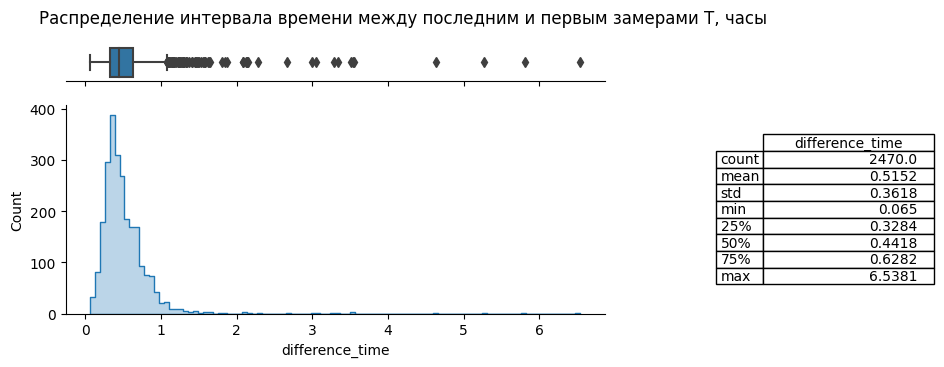

In [70]:
description(temp_first_last['difference_time']/60, 'Распределение интервала времени между последним и первым замерами Т, часы')

Чаще всего бывают партии продолжительностью около 26 мин (0.44 ч).\
Самая продолжительная партия - 6.5 ч

In [71]:
temp_first_last.drop(['time_min','time_max'], 1, inplace=True) # удаляем ненужные для ML признаки - время 1-ого/послед. замеров
display(temp_first_last.head(3)); print('Размер: ', temp_first_last.shape)

,T_first,T_last,difference_time
key,,,
1,1571.0,1613.0,14.350000
2,1581.0,1602.0,21.750000
3,1596.0,1599.0,21.666667


Размер:  (2470, 3)


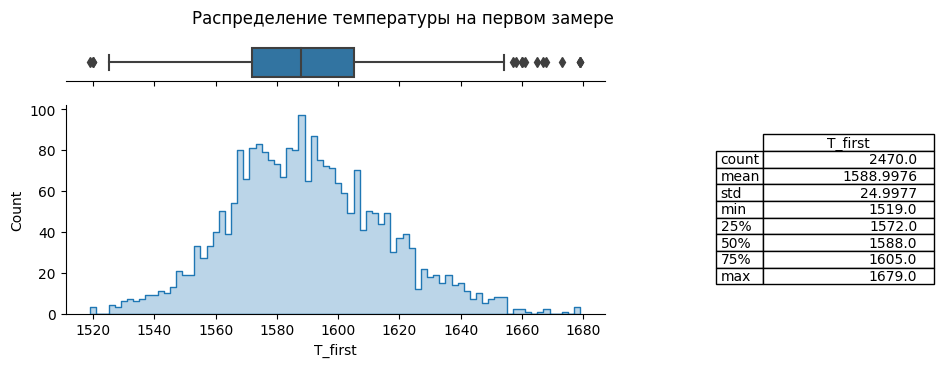

In [72]:
description(temp_first_last['T_first'], 'Распределение температуры на первом замере', bins=80)

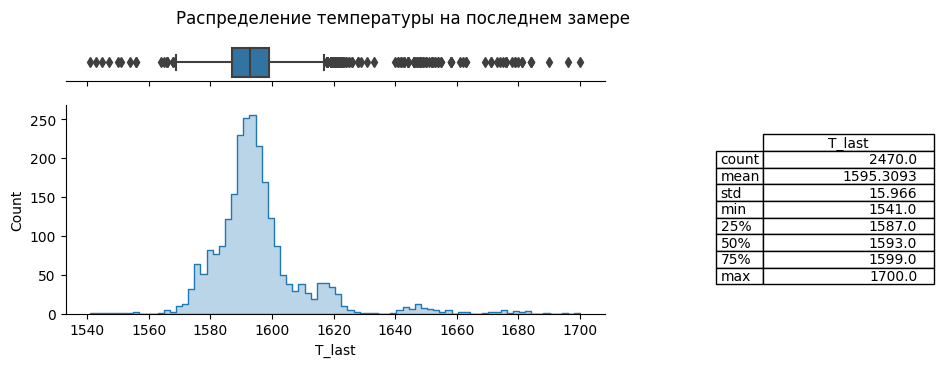

In [73]:
description(temp_first_last['T_last'], 'Распределение температуры на последнем замере', bins=80)

Медианы температур на первом и последнем замерах почти идентичны (1588/1593). Но при начале партии разброс Т значительно выше (std = 25/16).\
Это логично, так как промежуток времени может значительно отличаться после разливки стали из кислородно-конвертерной/электро-дуговой/мартеновской печи в печь-ковш. Соответсвенно расплав остынет на разную величину.\
Кроме того, и температура выхода стали из первичных печей может варьироваться.\
Температура же выхода из печи-ковша должна быть максимально приближена к определённой стандартом для подачи в машину непрерывной разливки.

### data_wire

In [74]:
table_info(data_wire)

<div class="alert alert-info">

Скрин виджетов из функции table_info(). Результат не сохраняется. Необходимо запускать при открытии тетради.

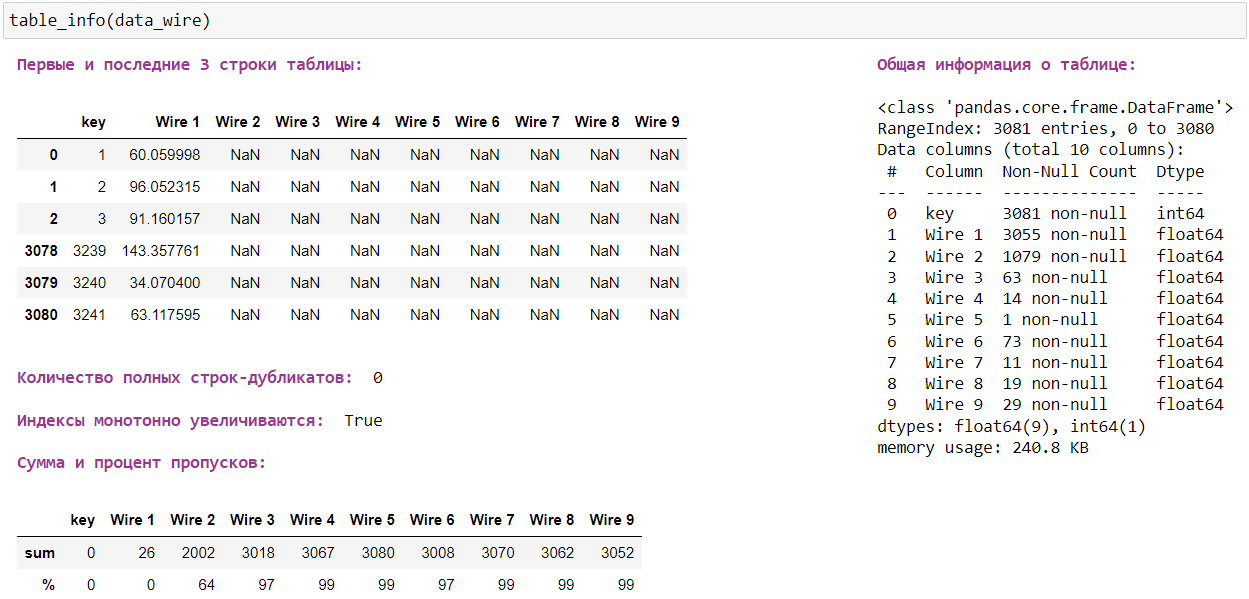
</div>

In [75]:
data_wire['key'].nunique()                                        # кол-во упомянутых партий в таблице

3081

Каждой строке соответсвует отдельная партия.\
Каждому столбцу соответсвует определённый проволочный материал (9 видов).

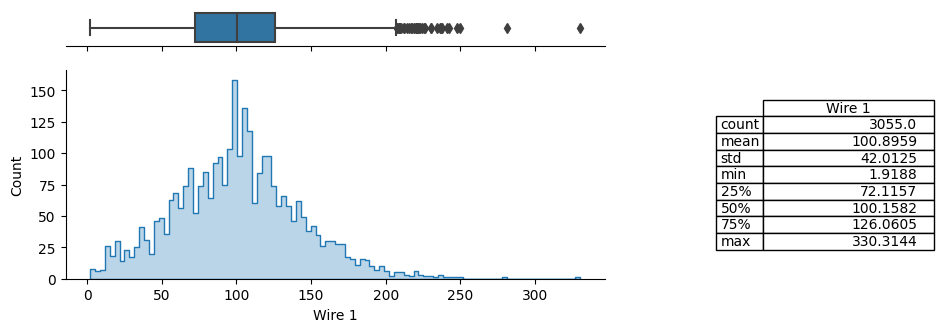

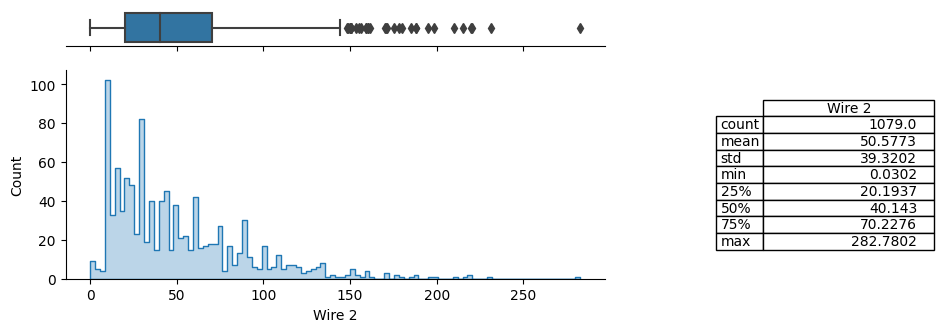

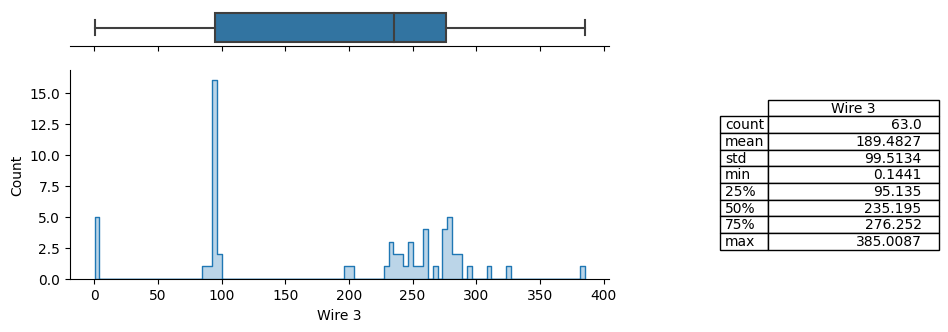

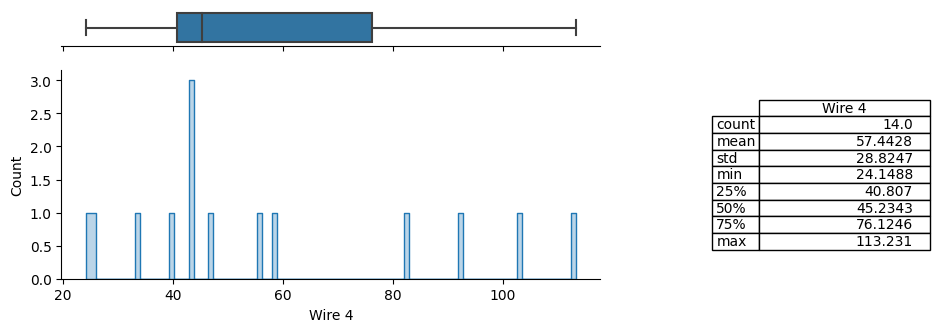

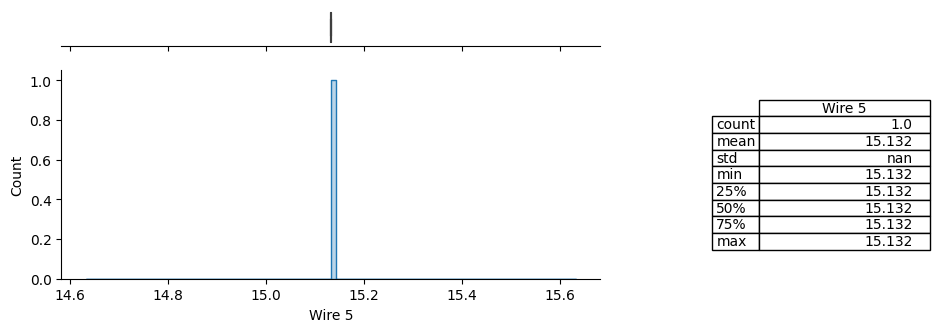

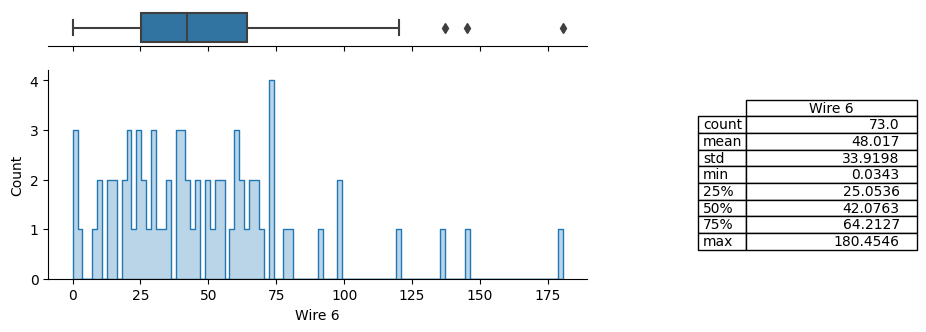

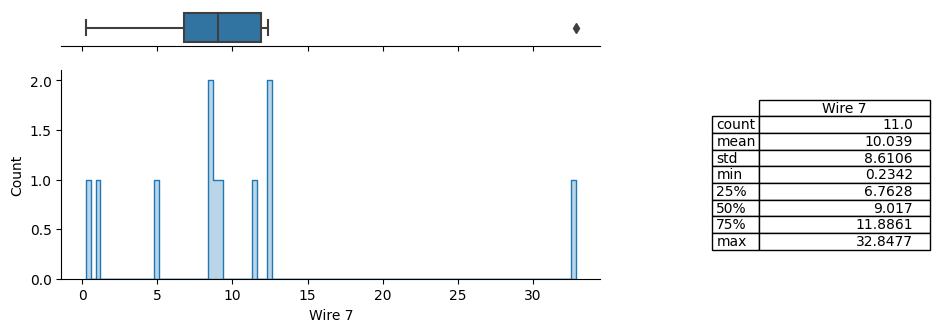

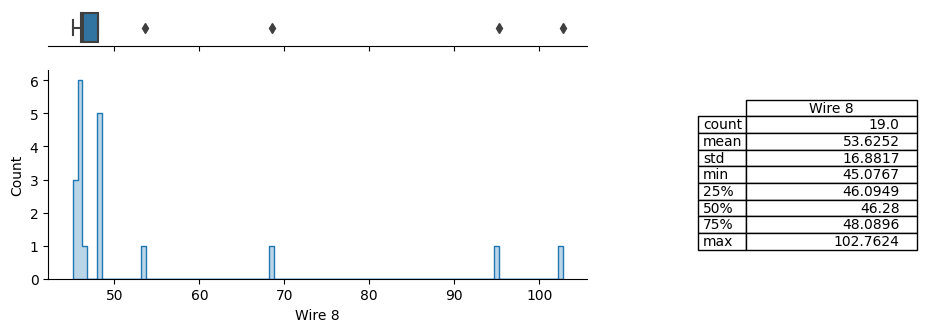

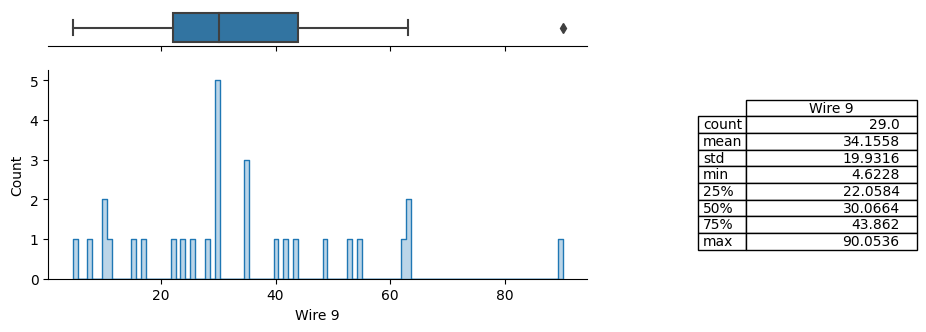

In [76]:
for col in data_wire.columns[1:]:                                 # распределение каждого из 9-ти видов проволочного материала
    description(data_wire[col])

Явных и однозначных выбросов/аномалий нет. Указанные количества вполне могли применяться в качестве присадок.\
Наиболее часто используемая проволочная присадка - Wire 1.

In [77]:
data_wire.fillna(0, inplace=True)                                                                   # заполняем пропуски нулями
data_wire.set_index('key', inplace=True)                                              # в качестве индекса устанавливаем партию
display(data_wire.head(3)); print('Размер: ', data_wire.shape)

,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
key,,,,,,,,,
1,60.059998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,96.052315,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,91.160157,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Размер:  (3081, 9)


### data_wire_time

In [78]:
table_info(data_wire_time)

<div class="alert alert-info">

Скрин виджетов из функции table_info(). Результат не сохраняется. Необходимо запускать при открытии тетради.

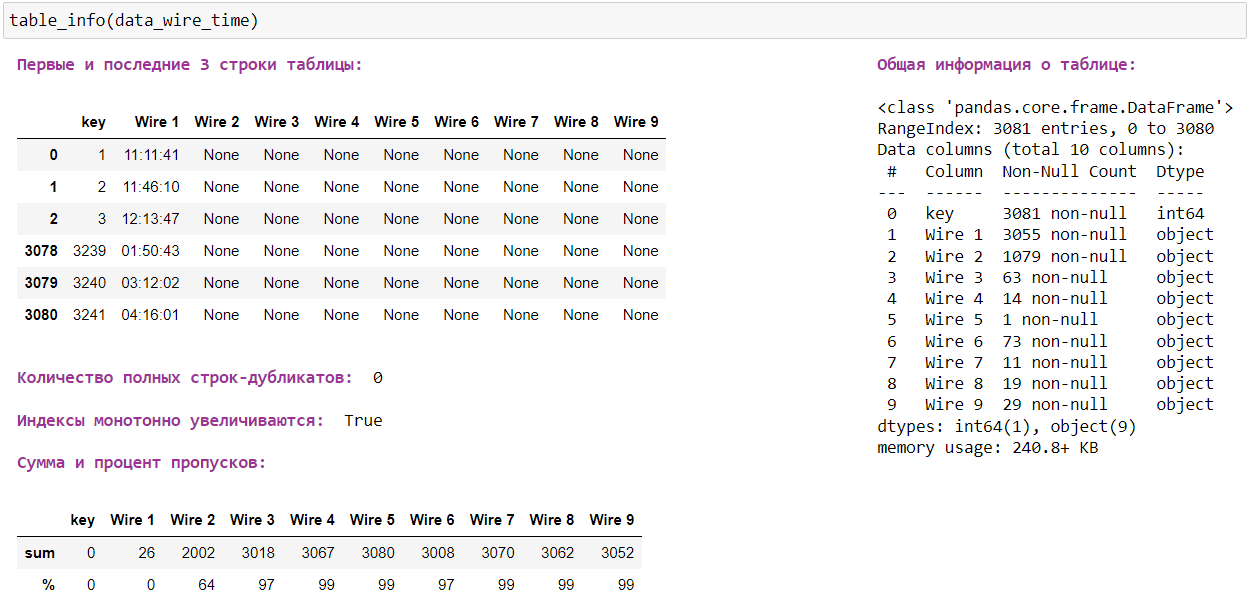
</div>

In [79]:
data_wire_time['key'].nunique()                                                 # кол-во упомянутых партий в таблице

3081

Каждой строке соответсвует отдельная партия.\
Каждому столбцу соответсвует определённый сыпучий материал (9 видов).

In [80]:
data_type(data_wire_time.iloc[:,1:])                                            # тип данных во временнЫх столбцах

{NoneType, datetime.time}

Проверим заполнена ли ячейка в таблице времени, если заполнена соответствующая ячейка в таблице объёма (и наоборот).\
Предварительно необходимо проверить, что "системы координат" в таблицах идентичны. То есть, наименования материалов и партий должны быть отсортированы идентично.

In [81]:
data_wire.index.is_monotonic_increasing                       # монотонный рост номеров партий в таблице с объёмами материалов

True

In [82]:
data_wire_time.set_index('key', inplace=True)                                         # в качестве индекса устанавливаем партию
data_wire_time.index.is_monotonic_increasing             # монотонный рост номеров партий в таблице с временем подачи материала

False

In [83]:
data_wire_time.sort_index(inplace=True)                                      # сортировка по номеру партии в таблице с временем

In [84]:
# количество несоответствий ячеек в двух таблицах по каждому типу проволочных материалов
((data_wire.isna()|data_wire == 0) != data_wire_time.isna()).sum().to_frame('count').T

,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,0,0,0,0,0,0,0,0,0


Ячейки в таблицах `data_wire` и `data_wire_time` соответсвуют друг другу.

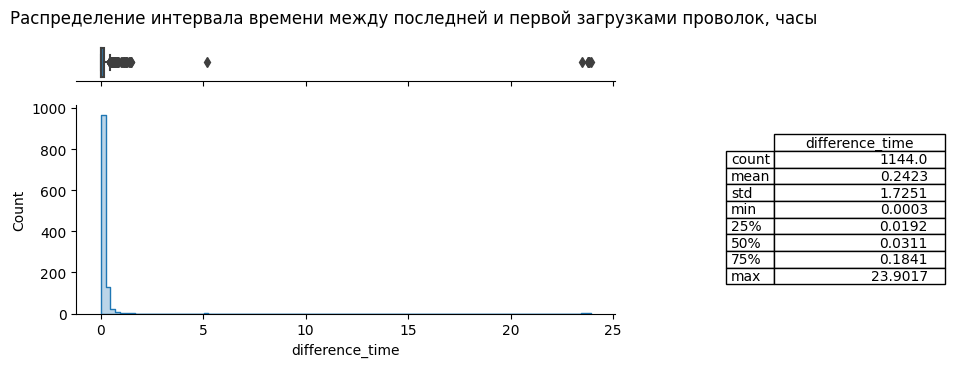

In [85]:
data_wire_time['difference_time'] = data_wire_time.apply(lambda x: time_difference_max_min(x)/60, 1)
description(data_wire_time['difference_time'][data_wire_time['difference_time']!=0], 
            'Распределение интервала времени между последней и первой загрузками проволок, часы')

Аномалий в данных нет. Пояснение выбросов (более 22 ч) идентично [пояснению](#bulk_time) про время подачи сыпучих материалов.

### Table join

Объединяем все полученные таблицы кроме `data_bulk_time` и `data_wire_time`. В планируемых ML-моделях не планируется выстраивать точную хронологию последовательности процессов.\
Объединение по номеру партии.

In [86]:
data = temp_first_last.join(data_arc_pivot, how='inner')\
                      .join(data_bulk,      how='inner')\
                      .join(data_gas,       how='inner')\
                      .join(data_wire,      how='inner')

table_info(data)

<div class="alert alert-info">

Скрин виджетов из функции table_info(). Результат не сохраняется. Необходимо запускать при открытии тетради.

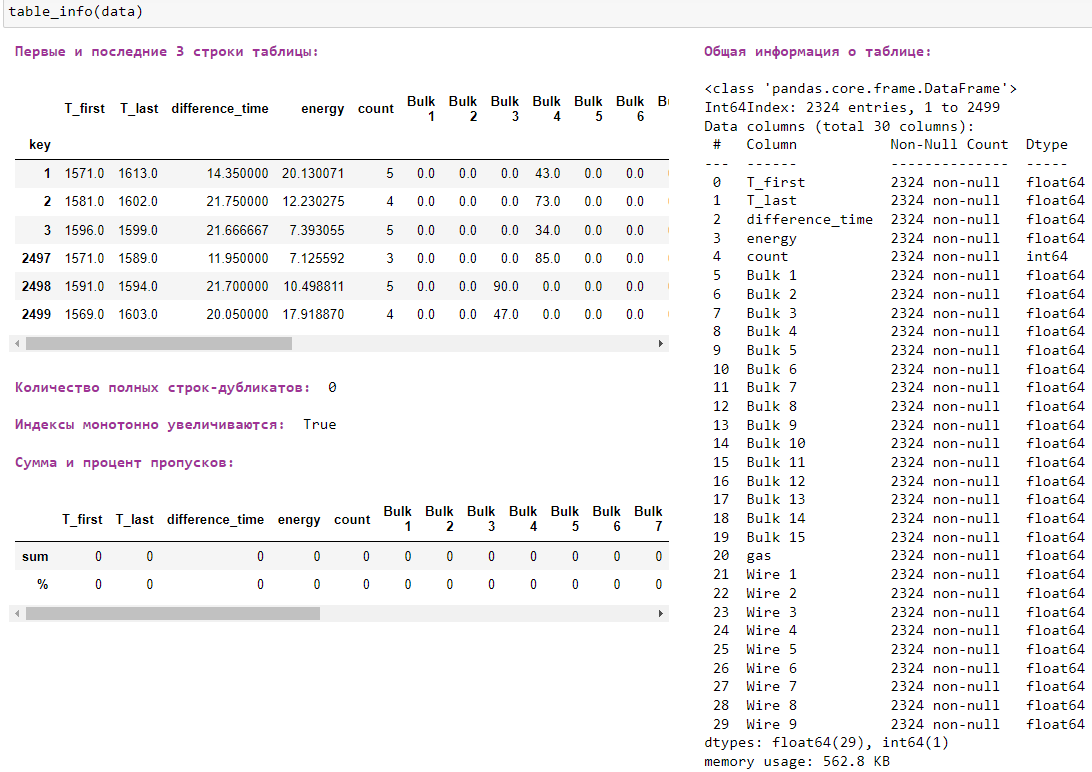
</div>

Подготовлена итоговая таблица для ML c признаками, характеризующими каждую партию:
* `T_first/last` - температуры сплава при первом/последнем замерах; 
* `difference_time` - продолжительность (разница времени последнего и первого замеров Т);
* `energy` - количество затраченной энергии;
* `count` - число циклов (нагревов);
* `Bulk 1...15` - объём каждого типа присадок;
* `gas` - объём поданного газа;
* `Wire 1...9` - объём поданной проволоки каждого типа.

### Feature correlation

Все признаки количественные (не категориальные). 

In [87]:
# поставим Т_last (целевой признак) на 1-ое место для удобства визуализации
data = data.reindex(['T_last', 'T_first', 'difference_time', 'energy', 'count', 'Bulk 1', 
                     'Bulk 2', 'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6', 'Bulk 7', 'Bulk 8',
                     'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 12', 'Bulk 13', 'Bulk 14',
                     'Bulk 15', 'gas', 'Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 5',
                     'Wire 6', 'Wire 7', 'Wire 8', 'Wire 9'], axis=1)

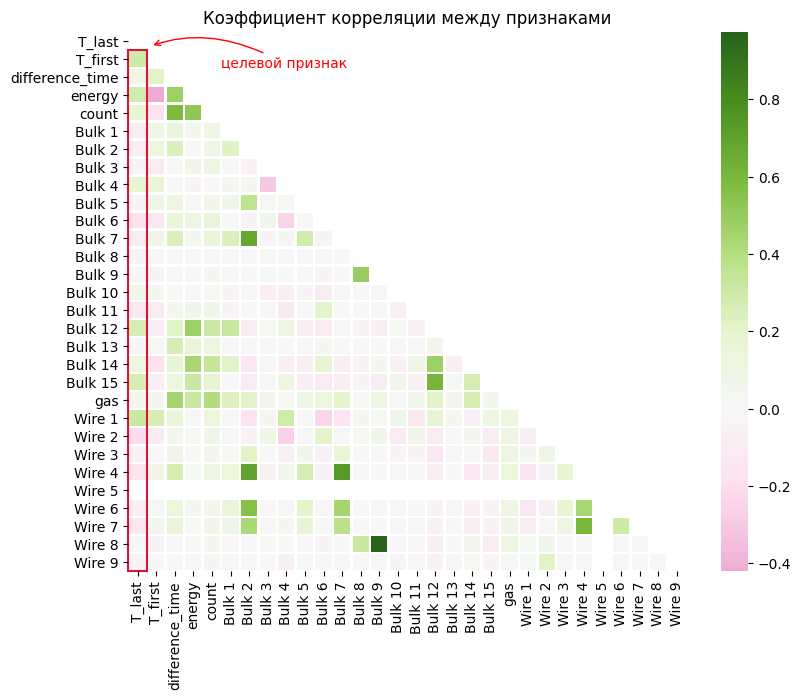

In [88]:
plt.figure(figsize=(9,7))
plt.title('Коэффициент корреляции между признаками')
data_corr = data.corr()
matrix = np.tri(len(data_corr)).T
ax = sns.heatmap(data_corr, cmap='PiYG', linewidth=1, center= 0, mask=matrix)

ax.add_patch(Rectangle(( 0, 1), 1, 29, fill=False, edgecolor='crimson', lw=1.5, clip_on=False))
ax.annotate('целевой признак', xy=(1.2, 0.8), xytext=(5, 2), color='red',
            arrowprops=dict(arrowstyle="->", connectionstyle="angle3, angleA=-30, angleB=20", color = 'red'))
plt.show()

Анализ графика [см. ниже](#corr) в Conclusion by EDA.

In [89]:
data.drop(['Wire 5', 'Wire 8'], 1, inplace=True) # удаление двух бесполезных признаков

<a id= 'Conclusion_by_EDA'></a>
### Conclusion by EDA

Из базы данных, схемы `steel` загружено 7 таблиц: 

* `data_arc`, размер (14876, 5), в т.ч. 3214 партий; максимальное число циклов (периодов нагрева) 16, минимальное - 1; распределения активной/реактивной мощностей нормальные; выброс откорректирован; в каких единицах измерения даны мощности в базе неясно, подразумеваем, что предоставлены как-то отмасштабированные значения; для ML будет использована только активная мощность; подготовлена таблица 'data_arc_pivot' с потраченной энергией на всю партию и числом циклов (нагревов) в каждой партии.
* `data_bulk`, (3129, 16), в т.ч. 3129 партий; выбросов нет;
* `data_bulk_time`, (3129, 16); таблица соответсвует 'data_bulk';
* `data_gas`, (3239, 2), в т.ч. 3239 партий; распределение нормальное, выбросов и аномалий нет; 
* `data_temp`, (15907, 3), в т.ч. 3216 партий; максимальное число замеров - 16, минимальное - 1; замеры с аномально низкой Т (<1500 °С) удалены (50 замеров, 6 партий); также удалены две партии с одним замером Т; кроме того удалены 738 партий (23%), в которых отсутствовали данные по последнему замеру температуры (у многих, возможно, у всех этих партий, есть информация только о первом замере);\
чаще всего бывают партии продолжительностью около 26 мин.; cамая продолжительная партия - 6.5 ч;\
подготовлена таблица 'temp_first_last' с первой/последней температурами замера в партии и продолжительностью партии; в получившейся таблице 2470 партий;\
медианы температур на первом и последнем замерах почти идентичны (1588/1593). Но при начале партии разброс Т значительно выше (std = 25/16).
* `data_wire`, (3081, 10), в т.ч. 3081 партия; выбросов и аномалий нет; наиболее часто используемая проволочная присадка - Wire 1;
* `data_wire_time`, (3081, 10), таблица соответствует 'data_wire'; аномалий в данных нет.

Объединённый датасет (2324, 30) получен из всех таблиц кроме 'data_bulk_time' и 'data_wire_time'. В планируемых ML-моделях не планируется выстраивать точную хронологию последовательности процессов.
Объединение по номеру партии.

Итоговая таблица для ML c признаками, характеризующими каждую партию: температуры сплава при первом/последнем замерах; продолжительность; количество затраченной энергии; число циклов; объём каждого типа присадок; объём поданного газа; объём поданной проволоки каждого типа.

<a id= 'corr'></a>Корреляционный анализ (см. график выше).
* На `T_last` больше всего оказывает положительное влияние `T_first` и `energy`.
* Незначительную отрицательную корреляцию с целевым признаком имеют `Bulk 6`, `Wire 2`; положительную - `Bulk 12`.
* `Wire 5` полностью пустой признак, подлежит удалению.
* Видим мультиколлинеарность между `Wire 8` и `Bulk 9`. Удалим `Wire 8`.
* Наблюдаем логичные закономерности: количество затраченной энергии тем выше, чем меньше начальная Т; энергия, число циклов и объём газа больше с более высоким временем партии.
* Есть закономерности по совместимости (или не) различных присадок: `Wire 4` часто используется совместно с `Bulk 2` и `Bulk 7`, `Bulk 15` c `Bulk 12`, `Wire 7` с `Wire 4`.

Итоговый размер датасета для ML (2324,28).

## Machine learning

### split, scaler

In [90]:
X = data.drop('T_last', 1)                               # разделение на обучающую и тестовую выборки
y = data['T_last']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=constant)

print (X_train.shape, y_train.shape)                     # размеры полученных выборок
print (X_test.shape,  y_test.shape)

(1743, 27) (1743,)
(581, 27) (581,)


### RandomForestRegressor

In [91]:
pipe = Pipeline([
    ('scale', StandardScaler()),
    ('RFR',   RandomForestRegressor(random_state=constant))])

In [92]:
parameters = {'RFR__max_depth':    [None] + [i for i in range(2, 7)],
              'RFR__n_estimators': range(20,201,20)}

In [93]:
grid = RandomizedSearchCV(estimator = pipe, param_distributions = parameters, 
                          random_state = constant, n_iter=20, scoring = 'neg_mean_absolute_error')

In [94]:
%%time
grid.fit(X_train, y_train)

CPU times: total: 2min 24s
Wall time: 2min 24s


RandomizedSearchCV(estimator=Pipeline(steps=[('scale', StandardScaler()),
                                             ('RFR',
                                              RandomForestRegressor(random_state=211223))]),
                   n_iter=20,
                   param_distributions={'RFR__max_depth': [None, 2, 3, 4, 5, 6],
                                        'RFR__n_estimators': range(20, 201, 20)},
                   random_state=211223, scoring='neg_mean_absolute_error')

In [95]:
grid_result(grid)

,params,mean_test_score
rank_test_score,,
1,"{'RFR__n_estimators': 200, 'RFR__max_depth': N...",6.057398
2,"{'RFR__n_estimators': 100, 'RFR__max_depth': N...",6.079955
3,"{'RFR__n_estimators': 120, 'RFR__max_depth': N...",6.082633
4,"{'RFR__n_estimators': 60, 'RFR__max_depth': None}",6.085942
5,"{'RFR__n_estimators': 160, 'RFR__max_depth': 6}",6.349239
6,"{'RFR__n_estimators': 180, 'RFR__max_depth': 6}",6.352201
7,"{'RFR__n_estimators': 80, 'RFR__max_depth': 6}",6.356538
8,"{'RFR__n_estimators': 40, 'RFR__max_depth': 6}",6.380788
9,"{'RFR__n_estimators': 20, 'RFR__max_depth': 6}",6.404083


Минимальное MAE = 6.057
    при гиперпараметрах {'RFR__n_estimators': 200, 'RFR__max_depth': None}.


### CatBoost

In [96]:
pipe = Pipeline([
    ('scale', StandardScaler()),
    ('CBR',   CatBoostRegressor(loss_function='MAE', 
                                eval_metric  ='MAE',
                                random_state =constant))])

In [97]:
parameters = {'CBR__learning_rate':         [0.5, 0.1, 0.01], 
              'CBR__depth':                 range(3, 8),
              'CBR__verbose':               [50],
              'CBR__early_stopping_rounds': [3],
              'CBR__iterations':            [1000]}

In [98]:
grid = GridSearchCV(estimator = pipe, param_grid = parameters, 
                    scoring   = 'neg_mean_absolute_error')

In [99]:
%%time
grid.fit(X_train, y_train)

0:	learn: 7.8697981	total: 133ms	remaining: 2m 13s
50:	learn: 4.8136391	total: 162ms	remaining: 3.01s
100:	learn: 4.2564431	total: 188ms	remaining: 1.67s
150:	learn: 3.9731226	total: 214ms	remaining: 1.2s
200:	learn: 3.8156985	total: 240ms	remaining: 953ms
250:	learn: 3.6536450	total: 265ms	remaining: 792ms
300:	learn: 3.5523708	total: 291ms	remaining: 676ms
350:	learn: 3.4934788	total: 317ms	remaining: 585ms
400:	learn: 3.4384014	total: 343ms	remaining: 512ms
450:	learn: 3.3774651	total: 368ms	remaining: 448ms
500:	learn: 3.3158219	total: 394ms	remaining: 392ms
550:	learn: 3.2716510	total: 419ms	remaining: 342ms
600:	learn: 3.2308007	total: 445ms	remaining: 296ms
650:	learn: 3.1735741	total: 471ms	remaining: 252ms
700:	learn: 3.1303398	total: 496ms	remaining: 212ms
750:	learn: 3.0924173	total: 522ms	remaining: 173ms
800:	learn: 3.0552507	total: 549ms	remaining: 136ms
850:	learn: 3.0116438	total: 575ms	remaining: 101ms
900:	learn: 2.9830911	total: 602ms	remaining: 66.1ms
950:	learn: 2.

750:	learn: 3.7487404	total: 404ms	remaining: 134ms
800:	learn: 3.7120746	total: 431ms	remaining: 107ms
850:	learn: 3.6751076	total: 457ms	remaining: 80ms
900:	learn: 3.6310525	total: 483ms	remaining: 53.1ms
950:	learn: 3.5888914	total: 510ms	remaining: 26.3ms
999:	learn: 3.5572569	total: 536ms	remaining: 0us
0:	learn: 7.9982069	total: 1.51ms	remaining: 1.5s
50:	learn: 6.0011153	total: 42.5ms	remaining: 792ms
100:	learn: 5.2877051	total: 70.6ms	remaining: 628ms
150:	learn: 4.9054998	total: 98ms	remaining: 551ms
200:	learn: 4.6757808	total: 125ms	remaining: 498ms
250:	learn: 4.4969307	total: 153ms	remaining: 457ms
300:	learn: 4.3498429	total: 181ms	remaining: 421ms
350:	learn: 4.2364772	total: 209ms	remaining: 386ms
400:	learn: 4.1352508	total: 237ms	remaining: 353ms
450:	learn: 4.0531377	total: 264ms	remaining: 322ms
500:	learn: 3.9938465	total: 292ms	remaining: 291ms
550:	learn: 3.9355155	total: 319ms	remaining: 260ms
600:	learn: 3.8669476	total: 346ms	remaining: 230ms
650:	learn: 3.8

300:	learn: 2.9935225	total: 211ms	remaining: 489ms
350:	learn: 2.8998097	total: 245ms	remaining: 453ms
400:	learn: 2.8028696	total: 279ms	remaining: 417ms
450:	learn: 2.7274620	total: 314ms	remaining: 382ms
500:	learn: 2.6668558	total: 348ms	remaining: 347ms
550:	learn: 2.5871787	total: 383ms	remaining: 312ms
600:	learn: 2.5297205	total: 418ms	remaining: 277ms
650:	learn: 2.4900768	total: 452ms	remaining: 242ms
700:	learn: 2.4527701	total: 487ms	remaining: 208ms
750:	learn: 2.4106866	total: 521ms	remaining: 173ms
800:	learn: 2.3816339	total: 555ms	remaining: 138ms
850:	learn: 2.3605859	total: 589ms	remaining: 103ms
900:	learn: 2.3329100	total: 624ms	remaining: 68.6ms
950:	learn: 2.3144843	total: 659ms	remaining: 33.9ms
999:	learn: 2.2938728	total: 693ms	remaining: 0us
0:	learn: 7.5957666	total: 1.34ms	remaining: 1.34s
50:	learn: 4.2299008	total: 53.8ms	remaining: 1s
100:	learn: 3.4979912	total: 90.9ms	remaining: 809ms
150:	learn: 3.1825748	total: 128ms	remaining: 717ms
200:	learn: 2.9

900:	learn: 3.0644561	total: 631ms	remaining: 69.3ms
950:	learn: 3.0287004	total: 666ms	remaining: 34.3ms
999:	learn: 3.0010169	total: 699ms	remaining: 0us
0:	learn: 7.9957696	total: 1.28ms	remaining: 1.28s
50:	learn: 5.6877814	total: 41.4ms	remaining: 770ms
100:	learn: 4.9546299	total: 81.5ms	remaining: 725ms
150:	learn: 4.5484063	total: 120ms	remaining: 675ms
200:	learn: 4.2813308	total: 158ms	remaining: 629ms
250:	learn: 4.0656516	total: 196ms	remaining: 586ms
300:	learn: 3.9210069	total: 242ms	remaining: 562ms
350:	learn: 3.8189396	total: 285ms	remaining: 526ms
400:	learn: 3.6929792	total: 340ms	remaining: 507ms
450:	learn: 3.5948772	total: 382ms	remaining: 465ms
500:	learn: 3.5092025	total: 420ms	remaining: 418ms
550:	learn: 3.4274904	total: 458ms	remaining: 374ms
600:	learn: 3.3636945	total: 496ms	remaining: 329ms
650:	learn: 3.3098135	total: 534ms	remaining: 286ms
700:	learn: 3.2663929	total: 572ms	remaining: 244ms
750:	learn: 3.2091878	total: 609ms	remaining: 202ms
800:	learn: 

450:	learn: 2.1639855	total: 430ms	remaining: 524ms
500:	learn: 2.1230567	total: 477ms	remaining: 475ms
550:	learn: 2.0584448	total: 523ms	remaining: 426ms
600:	learn: 2.0314725	total: 570ms	remaining: 378ms
650:	learn: 1.9748599	total: 617ms	remaining: 331ms
700:	learn: 1.9428846	total: 664ms	remaining: 283ms
750:	learn: 1.9020657	total: 710ms	remaining: 235ms
800:	learn: 1.8647658	total: 756ms	remaining: 188ms
850:	learn: 1.8298830	total: 801ms	remaining: 140ms
900:	learn: 1.8023817	total: 847ms	remaining: 93.1ms
950:	learn: 1.7733630	total: 892ms	remaining: 46ms
999:	learn: 1.7455570	total: 936ms	remaining: 0us
0:	learn: 7.5254653	total: 1.6ms	remaining: 1.6s
50:	learn: 3.7745419	total: 57.3ms	remaining: 1.06s
100:	learn: 3.1533640	total: 108ms	remaining: 957ms
150:	learn: 2.8328706	total: 157ms	remaining: 881ms
200:	learn: 2.6364099	total: 206ms	remaining: 820ms
250:	learn: 2.4376525	total: 256ms	remaining: 764ms
300:	learn: 2.3259971	total: 306ms	remaining: 710ms
350:	learn: 2.246

999:	learn: 2.4625603	total: 929ms	remaining: 0us
0:	learn: 7.9887445	total: 1.71ms	remaining: 1.71s
50:	learn: 5.3075928	total: 59.1ms	remaining: 1.1s
100:	learn: 4.5596796	total: 110ms	remaining: 979ms
150:	learn: 4.1032317	total: 161ms	remaining: 903ms
200:	learn: 3.7809173	total: 211ms	remaining: 839ms
250:	learn: 3.5728951	total: 261ms	remaining: 778ms
300:	learn: 3.3848101	total: 313ms	remaining: 726ms
350:	learn: 3.2434160	total: 368ms	remaining: 680ms
400:	learn: 3.1131427	total: 421ms	remaining: 629ms
450:	learn: 3.0137131	total: 475ms	remaining: 578ms
500:	learn: 2.9234200	total: 528ms	remaining: 526ms
550:	learn: 2.8380595	total: 582ms	remaining: 474ms
600:	learn: 2.7625323	total: 635ms	remaining: 421ms
650:	learn: 2.7037612	total: 685ms	remaining: 367ms
700:	learn: 2.6572199	total: 738ms	remaining: 315ms
750:	learn: 2.6189714	total: 793ms	remaining: 263ms
800:	learn: 2.5806197	total: 842ms	remaining: 209ms
850:	learn: 2.5412892	total: 892ms	remaining: 156ms
900:	learn: 2.50

600:	learn: 1.4219691	total: 811ms	remaining: 539ms
650:	learn: 1.3828328	total: 881ms	remaining: 473ms
700:	learn: 1.3417460	total: 944ms	remaining: 403ms
750:	learn: 1.3153063	total: 1.01s	remaining: 334ms
800:	learn: 1.2852285	total: 1.07s	remaining: 267ms
850:	learn: 1.2354283	total: 1.15s	remaining: 201ms
900:	learn: 1.1950942	total: 1.21s	remaining: 133ms
950:	learn: 1.1457912	total: 1.28s	remaining: 65.9ms
999:	learn: 1.1078346	total: 1.34s	remaining: 0us
0:	learn: 7.1804151	total: 2.3ms	remaining: 2.3s
50:	learn: 3.3149381	total: 75.5ms	remaining: 1.4s
100:	learn: 2.6709918	total: 145ms	remaining: 1.29s
150:	learn: 2.2826400	total: 217ms	remaining: 1.22s
200:	learn: 2.0025954	total: 292ms	remaining: 1.16s
250:	learn: 1.8506360	total: 365ms	remaining: 1.09s
300:	learn: 1.7297945	total: 441ms	remaining: 1.02s
350:	learn: 1.6304998	total: 550ms	remaining: 1.02s
400:	learn: 1.5533938	total: 627ms	remaining: 937ms
450:	learn: 1.4724562	total: 698ms	remaining: 850ms
500:	learn: 1.398

150:	learn: 3.6286079	total: 224ms	remaining: 1.26s
200:	learn: 3.2744154	total: 296ms	remaining: 1.18s
250:	learn: 3.0335769	total: 368ms	remaining: 1.1s
300:	learn: 2.8659043	total: 439ms	remaining: 1.02s
350:	learn: 2.7044608	total: 513ms	remaining: 948ms
400:	learn: 2.5801226	total: 584ms	remaining: 873ms
450:	learn: 2.4589645	total: 656ms	remaining: 799ms
500:	learn: 2.3735916	total: 729ms	remaining: 727ms
550:	learn: 2.2939145	total: 801ms	remaining: 653ms
600:	learn: 2.2197041	total: 872ms	remaining: 579ms
650:	learn: 2.1605306	total: 943ms	remaining: 505ms
700:	learn: 2.1068377	total: 1.01s	remaining: 433ms
750:	learn: 2.0641827	total: 1.08s	remaining: 360ms
800:	learn: 2.0221902	total: 1.16s	remaining: 287ms
850:	learn: 1.9830763	total: 1.23s	remaining: 215ms
900:	learn: 1.9419586	total: 1.3s	remaining: 143ms
950:	learn: 1.9184024	total: 1.37s	remaining: 70.5ms
999:	learn: 1.8843372	total: 1.44s	remaining: 0us
0:	learn: 7.9012893	total: 6.38ms	remaining: 6.38s
50:	learn: 5.062

750:	learn: 0.8428587	total: 1.49s	remaining: 493ms
800:	learn: 0.8088504	total: 1.58s	remaining: 393ms
850:	learn: 0.7866172	total: 1.68s	remaining: 294ms
900:	learn: 0.7622394	total: 1.78s	remaining: 195ms
950:	learn: 0.7419816	total: 1.88s	remaining: 96.6ms
999:	learn: 0.7175708	total: 1.97s	remaining: 0us
0:	learn: 6.9899560	total: 2.86ms	remaining: 2.86s
50:	learn: 2.5703600	total: 114ms	remaining: 2.12s
100:	learn: 2.0256229	total: 220ms	remaining: 1.96s
150:	learn: 1.7429564	total: 326ms	remaining: 1.83s
200:	learn: 1.5703846	total: 432ms	remaining: 1.72s
250:	learn: 1.3922870	total: 537ms	remaining: 1.6s
300:	learn: 1.2803065	total: 643ms	remaining: 1.49s
350:	learn: 1.1769996	total: 750ms	remaining: 1.39s
400:	learn: 1.0987141	total: 876ms	remaining: 1.31s
450:	learn: 1.0482375	total: 981ms	remaining: 1.19s
500:	learn: 0.9936596	total: 1.09s	remaining: 1.08s
550:	learn: 0.9400788	total: 1.2s	remaining: 974ms
600:	learn: 0.9096643	total: 1.3s	remaining: 865ms
650:	learn: 0.8784

300:	learn: 2.2167118	total: 693ms	remaining: 1.61s
350:	learn: 2.0767908	total: 800ms	remaining: 1.48s
400:	learn: 1.9612648	total: 906ms	remaining: 1.35s
450:	learn: 1.8505594	total: 1.01s	remaining: 1.23s
500:	learn: 1.7656578	total: 1.12s	remaining: 1.12s
550:	learn: 1.7043231	total: 1.23s	remaining: 1s
600:	learn: 1.6492769	total: 1.34s	remaining: 888ms
650:	learn: 1.5983103	total: 1.45s	remaining: 775ms
700:	learn: 1.5454924	total: 1.56s	remaining: 664ms
750:	learn: 1.4994386	total: 1.67s	remaining: 554ms
800:	learn: 1.4425999	total: 1.78s	remaining: 442ms
850:	learn: 1.4071824	total: 1.89s	remaining: 331ms
900:	learn: 1.3741717	total: 2s	remaining: 220ms
950:	learn: 1.3455262	total: 2.11s	remaining: 109ms
999:	learn: 1.3224485	total: 2.21s	remaining: 0us
0:	learn: 7.8699632	total: 2.46ms	remaining: 2.45s
50:	learn: 4.6800407	total: 131ms	remaining: 2.44s
100:	learn: 3.6719495	total: 242ms	remaining: 2.15s
150:	learn: 3.1007400	total: 369ms	remaining: 2.07s
200:	learn: 2.7368160	

CPU times: total: 14min 26s
Wall time: 1min 50s


GridSearchCV(estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('CBR',
                                        <catboost.core.CatBoostRegressor object at 0x000002457E080FD0>)]),
             param_grid={'CBR__depth': range(3, 8),
                         'CBR__early_stopping_rounds': [3],
                         'CBR__iterations': [1000],
                         'CBR__learning_rate': [0.5, 0.1, 0.01],
                         'CBR__verbose': [50]},
             scoring='neg_mean_absolute_error')

In [100]:
pd.DataFrame(grid.cv_results_)[['param_CBR__depth', 'param_CBR__early_stopping_rounds',
                                'param_CBR__learning_rate', 'mean_test_score', 'rank_test_score']]\
                              .sort_values('rank_test_score')\
                              .set_index('rank_test_score')

,param_CBR__depth,param_CBR__early_stopping_rounds,param_CBR__learning_rate,mean_test_score
rank_test_score,,,,
1,3,3,0.1,-5.702049
2,4,3,0.1,-5.746591
3,5,3,0.1,-5.848207
4,5,3,0.01,-5.853705
5,6,3,0.01,-5.879194
6,7,3,0.01,-5.882501
7,6,3,0.1,-5.893048
8,4,3,0.01,-5.907796
9,7,3,0.1,-5.927046


In [101]:
-grid.best_score_.round(3)                   # лучшее MAE

5.702

In [102]:
grid.best_params_                            # гиперпараметры при которых лучшее MAE

{'CBR__depth': 3,
 'CBR__early_stopping_rounds': 3,
 'CBR__iterations': 1000,
 'CBR__learning_rate': 0.1,
 'CBR__verbose': 50}

### Neural network

In [103]:
def neural_net(model, X_train, X_valid, y_train, y_valid, l2_lambda=0, print_info = True):
    '''вычисляет минимальный MAE в двойном цикле по эпохам и батчам; сообщает на какой эпохе достигнут лучший MAE_test;
       выводит динамику изменения MAE на графике;
       возможна регуляризация весов чере l2_lambda'''

    torch.manual_seed(constant)
    
    # если GPU доступен, создаём тензоры для работы на GPU; иначе - обычные тензоры для CPU
    if torch.cuda.is_available():
        X_train_ = torch.cuda.FloatTensor(X_train)
        X_test_  = torch.cuda.FloatTensor(X_valid)
        y_train_ = torch.cuda.FloatTensor(y_train)
        y_test_  = torch.cuda.FloatTensor(y_valid)
    else:
        X_train_ = torch.Tensor(X_train)
        X_test_  = torch.Tensor(X_valid)
        y_train_ = torch.Tensor(y_train)
        y_test_  = torch.Tensor(y_valid)

    global prediction_test_best, df_mae
    count_higher_mae = 0
    df_mae = pd.DataFrame(columns=['train', 'valid'])
    for epoch in range(num_epochs):

        # случайная перестановка объектов
        order = np.random.permutation(len(X_train_))
        for batch_idx in range(num_batches):
            start_index = batch_idx*batch_size

            # получение индексов текущего батча
            batch_indexes = order[start_index:start_index+batch_size]
            X_batch = X_train_[batch_indexes]
            y_batch = y_train_[batch_indexes]

            optimizer.zero_grad()
            prediction = model.forward(X_train_)
            loss_value = loss(prediction.flatten(), y_train_)
            loss_value = loss_value + l2_lambda*sum(p.pow(2).sum() for p in model.parameters()) # добавленная регуляризация
            loss_value.backward()
            optimizer.step()

        # фиксирование MAE в конце каждой эпохи
        mae_train = loss_value.item()

        # расчёт MAE на тестовой выборке; блок кода для расчёта метрик в режиме инференса
        with torch.no_grad():
            model.eval()
            prediction_test = model.forward(X_test_)
            mae_test = loss(prediction_test.flatten(), y_test_).item()
            model.train()

        # фиксирование начальных MAE и предсказания на случай, если в самом начале попали в идеальное предсказание
        if epoch == 0:
            mae_test_best = mae_test
            prediction_test_best = prediction_test
            mae_test_last = mae_test             # техническое присвоение для начальной эпохи чтобы сработал if ниже

        # формирование df c MAE-train/test на каждой 1-ой эпохе или последней
        if epoch%1 == 0 or epoch+1 == num_epochs:
            df_mae = pd.concat([df_mae, pd.DataFrame([[mae_train, mae_test]], [epoch], ['train', 'valid'])])

        # прерывание цикла, если в течении 3 эпох подряд mae_test увеличивается
        if mae_test >= mae_test_last and count_higher_mae < 3:
            count_higher_mae+=1
            mae_test_last = mae_test
        elif mae_test < mae_test_last:
            count_higher_mae = 0
            mae_test_best = mae_test
            mae_test_last = mae_test
            prediction_test_best = prediction_test
        else:
            print(' '*50, end='\r') # закрашивает последнее значение счётчика эпох
            break

        print (f"Вычисляется эпоха {epoch+1} из {num_epochs}", end='\r') # счётчик эпох

    if print_info == True:
        # печать графика
        f, ax = plt.subplots(1,2, gridspec_kw={"width_ratios": (0.8, 0.2)}, figsize=(10,3))
        df_mae.plot(grid=True, title='MAE на обучающей и валидационной выборках', xlabel='эпоха', ax=ax[0])
        plt.text(0, 0.75, f"Наименьшее (на последних эпохах) \nMAE_valid  = {mae_test_best:.4f}\
            достигнуто на {epoch-3}-ой эпохе.\nMAE_train = {mae_train:.4f}")
        plt.text(0, 0.5,  f"Наименьшее (на всех эпохах) \nMAE_valid  = {df_mae['valid'].min():.4f}\
            достигнуто на {df_mae['valid'].idxmin()}-ой эпохе.\nMAE_train = {mae_train:.4f}")
        plt.text(0, 0, f"num_epochs_max = {num_epochs}, \nbatch_size = {batch_size},\
            \nlr = {optimizer.state_dict()['param_groups'][0]['lr']}, \nl2_lambda = {l2_lambda}", color='grey')
        plt.axis('off'); plt.show()

In [104]:
def neural_net_cv(model, X, y, n_splits=5, l2_lambda=0, print_info = False):
    '''с помощью кросс-валидации возвращает средние по фолдам MAE с номером итерации;
    в каждом фолде находится лучшая MAE; каждый фолд скаллируется отдельно; метрики и итерации по всем фолдам в mae_iter'''
    global mae_iter
    mae_iter = []
    kf = KFold(n_splits=n_splits)
    for train_idx, valid_idx in notebook.tqdm(kf.split(X)):
        
        scaler = StandardScaler()
        scaler.fit(X[train_idx])
        X_train = scaler.transform(X[train_idx])
        X_valid = scaler.transform(X[valid_idx])
        y_train = y[train_idx]
        y_valid = y[valid_idx]
        
        neural_net(model, X_train, X_valid, y_train, y_valid, print_info = print_info, l2_lambda=l2_lambda)
        mae_iter.append([df_mae['valid'].min(), 
                         df_mae['valid'].idxmin()])
        
        for layer in model.children():                          # сброс параметров модели после последнего обучения
            if hasattr(layer, 'reset_parameters'):
                layer.reset_parameters()
        
    mae_iter_mean = np.array(mae_iter).mean(axis=0)
    
    cprint(f'MAE_mean = {mae_iter_mean[0]: .3f}, iteration_mean = {mae_iter_mean[1]: .0f}', 'magenta', attrs=['bold'])

#### Variant 1

In [105]:
class NeuralNet(nn.Module):
    def __init__ (self, n_in_neurons, n_hidden_neurons_1, n_out_neurons):
        super(NeuralNet,self).__init__()

        self.fc1  = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.act1 = nn.ReLU()
        self.fc2  = nn.Linear(n_hidden_neurons_1, n_out_neurons)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)

        return x

In [106]:
model     = NeuralNet(27,5,1).to(device)
loss      = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [107]:
batch_size  = 100
num_epochs  = 1000
num_batches = ceil(len(X_train)/batch_size)

In [108]:
neural_net_cv(model, X_train.values, y_train.values)

0it [00:00, ?it/s]

MAE_mean =  16.008, iteration_mean =  372


#### Variant 2

In [109]:
class NeuralNet(nn.Module):
    def __init__ (self, n_in_neurons, n_hidden_neurons_1, n_out_neurons):
        super(NeuralNet,self).__init__()

        self.fc1  = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.act1 = nn.ReLU()
        self.fc2  = nn.Linear(n_hidden_neurons_1, n_out_neurons)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)

        return x

In [110]:
model     = NeuralNet(27,5,1).to(device)
loss      = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

In [111]:
batch_size  = 100
num_epochs  = 1000
num_batches = ceil(len(X_train)/batch_size)

In [112]:
neural_net_cv(model, X_train.values, y_train.values)

0it [00:00, ?it/s]

MAE_mean =  13.015, iteration_mean =  84


#### Variant 3

In [113]:
class NeuralNet(nn.Module):
    def __init__ (self, n_in_neurons, n_hidden_neurons_1, n_out_neurons):
        super(NeuralNet,self).__init__()

        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(n_hidden_neurons_1, n_out_neurons)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)

        return x

In [114]:
model     = NeuralNet(27,10,1).to(device)
loss      = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

In [115]:
batch_size  = 100
num_epochs  = 1000
num_batches = ceil(len(X_train)/batch_size)

In [116]:
neural_net_cv(model, X_train.values, y_train.values)

0it [00:00, ?it/s]

MAE_mean =  12.460, iteration_mean =  36


#### Variant 4

In [117]:
class NeuralNet(nn.Module):
    def __init__ (self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons):
        super(NeuralNet,self).__init__()

        self.fc1  = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.act1 = nn.ReLU()
        self.fc2  = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.act2 = nn.Sigmoid()
        self.fc3  = nn.Linear(n_hidden_neurons_2, n_out_neurons)


    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc3(x)

        return x

In [118]:
model     = NeuralNet(27,10,3, 1).to(device)
loss      = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

In [119]:
batch_size  = 100
num_epochs  = 1000
num_batches = ceil(len(X_train)/batch_size)

In [120]:
neural_net_cv(model, X_train.values, y_train.values)

0it [00:00, ?it/s]

MAE_mean =  8.131, iteration_mean =  250


#### Variant 5

In [121]:
class NeuralNet(nn.Module):
    def __init__ (self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons):
        super(NeuralNet,self).__init__()

        self.fc1  = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.bn1  = nn.BatchNorm1d(n_hidden_neurons_1)
        self.act1 = nn.Sigmoid()
        self.fc2  = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.act2 = nn.Sigmoid()
        self.fc3  = nn.Linear(n_hidden_neurons_2, n_out_neurons)


    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc3(x)

        return x

In [122]:
model     = NeuralNet(27,10,3, 1).to(device)
loss      = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

In [123]:
batch_size  = 100
num_epochs  = 1000
num_batches = ceil(len(X_train)/batch_size)

In [124]:
neural_net_cv(model, X_train.values, y_train.values)

0it [00:00, ?it/s]

MAE_mean =  8.134, iteration_mean =  278


#### Variant 6

In [125]:
class NeuralNet(nn.Module):
    def __init__ (self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons):
        super(NeuralNet,self).__init__()

        self.fc1  = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.bn1  = nn.BatchNorm1d(n_hidden_neurons_1)
        self.act1 = nn.Sigmoid()
        self.fc2  = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.act2 = nn.Sigmoid()
        self.fc3  = nn.Linear(n_hidden_neurons_2, n_out_neurons)


    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc3(x)

        return x

In [126]:
model     = NeuralNet(27,10,10, 1).to(device)
loss      = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

In [127]:
batch_size = 100
num_epochs = 10000
num_batches = ceil(len(X_train)/batch_size)

In [128]:
neural_net_cv(model, X_train.values, y_train.values)

0it [00:00, ?it/s]

MAE_mean =  7.688, iteration_mean =  180


#### Variant 7

In [129]:
class NeuralNet(nn.Module):
    def __init__ (self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons):
        super(NeuralNet,self).__init__()

        self.fc1  = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.bn1  = nn.BatchNorm1d(n_hidden_neurons_1)
        self.act1 = nn.Sigmoid()
        self.fc2  = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.act2 = nn.Sigmoid()
        self.fc3  = nn.Linear(n_hidden_neurons_2, n_out_neurons)


    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc3(x)

        return x

In [130]:
model     = NeuralNet(27,10,10, 1).to(device)
loss      = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)

In [131]:
batch_size  = 100
num_epochs  = 5000
num_batches = ceil(len(X_train)/batch_size)

In [132]:
neural_net_cv(model, X_train.values, y_train.values)

0it [00:00, ?it/s]

MAE_mean =  6.977, iteration_mean =  255


#### Variant 8

In [133]:
class NeuralNet(nn.Module):
    def __init__ (self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_hidden_neurons_3, n_out_neurons):
        super(NeuralNet,self).__init__()

        self.fc1  = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.bn1  = nn.BatchNorm1d(n_hidden_neurons_1)
        self.act1 = nn.ReLU()
        self.fc2  = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.act2 = nn.Sigmoid()
        self.fc3  = nn.Linear(n_hidden_neurons_2, n_hidden_neurons_3)
        self.act3 = nn.Sigmoid()
        self.fc4  = nn.Linear(n_hidden_neurons_3, n_out_neurons)


    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc3(x)
        x = self.act3(x)
        x = self.fc4(x)

        return x

In [134]:
model     = NeuralNet(27,15,15,15,1).to(device)
loss      = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)

In [135]:
batch_size  = 100
num_epochs  = 5000
num_batches = ceil(len(X_train)/batch_size)

In [136]:
neural_net_cv(model, X_train.values, y_train.values)

0it [00:00, ?it/s]

MAE_mean =  8.127, iteration_mean =  234


#### Variant 9

In [137]:
class NeuralNet(nn.Module):
    def __init__ (self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_hidden_neurons_3, n_out_neurons):
        super(NeuralNet,self).__init__()

        self.fc1  = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.bn1  = nn.BatchNorm1d(n_hidden_neurons_1)
        self.act1 = nn.ReLU()
        self.fc2  = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.act2 = nn.Sigmoid()
        self.fc3  = nn.Linear(n_hidden_neurons_2, n_hidden_neurons_3)
        self.act3 = nn.ReLU()
        self.fc4  = nn.Linear(n_hidden_neurons_3, n_out_neurons)


    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc3(x)
        x = self.act3(x)
        x = self.fc4(x)

        return x

In [138]:
model     = NeuralNet(27,15,15,15,1).to(device)
loss      = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)

In [139]:
batch_size  = 100
num_epochs  = 5000
num_batches = ceil(len(X_train)/batch_size)

In [140]:
neural_net_cv(model, X_train.values, y_train.values)

0it [00:00, ?it/s]

MAE_mean =  6.637, iteration_mean =  36


#### Variant 10

In [141]:
class NeuralNet(nn.Module):
    def __init__ (self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_hidden_neurons_3, n_out_neurons):
        super(NeuralNet,self).__init__()

        self.fc1  = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.bn1  = nn.BatchNorm1d(n_hidden_neurons_1)
        self.act1 = nn.ReLU()
        self.fc2  = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.act2 = nn.Sigmoid()
        self.fc3  = nn.Linear(n_hidden_neurons_2, n_hidden_neurons_3)
        self.act3 = nn.ReLU()
        self.fc4  = nn.Linear(n_hidden_neurons_3, n_out_neurons)


    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc3(x)
        x = self.act3(x)
        x = self.fc4(x)

        return x

In [142]:
model     = NeuralNet(27,15,15,15,1).to(device)
loss      = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.06)

In [143]:
batch_size  = 100
num_epochs  = 5000
num_batches = ceil(len(X_train)/batch_size)

In [144]:
neural_net_cv(model, X_train.values, y_train.values)

0it [00:00, ?it/s]

MAE_mean =  7.161, iteration_mean =  32


#### Variant 11

In [145]:
class NeuralNet(nn.Module):
    def __init__ (self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_hidden_neurons_3, n_out_neurons):
        super(NeuralNet,self).__init__()

        self.fc1  = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.bn1  = nn.BatchNorm1d(n_hidden_neurons_1)
        self.act1 = nn.ReLU()
        self.fc2  = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.act2 = nn.Sigmoid()
        self.fc3  = nn.Linear(n_hidden_neurons_2, n_hidden_neurons_3)
        self.act3 = nn.ReLU()
        self.fc4  = nn.Linear(n_hidden_neurons_3, n_out_neurons)


    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc3(x)
        x = self.act3(x)
        x = self.fc4(x)

        return x

In [146]:
model     = NeuralNet(27,5,5,5,1).to(device)
loss      = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.06)

In [147]:
batch_size  = 100
num_epochs  = 145
num_batches = ceil(len(X_train)/batch_size)

In [148]:
neural_net_cv(model, X_train.values, y_train.values)

0it [00:00, ?it/s]

MAE_mean =  6.160, iteration_mean =  62


<a id= 'Conclusion_by_ML'></a>
### Conclusion by ML

Построен ряд моделей, подобраны гиперпараметры.
* **RandomForestRegressor**; MAE = <font color='red'>6.057</font> при {'n_estimators': 200, 'max_depth': None}.
* **CatBoost**; MAE = <font color='red'>5.702</font> при depth = 3, числе итераций  1000, learning_rate = 0.1.
* **Neural network**; протестировано несколько архитектур с полносвязными слоями; пробовались сети с 1, 2, 3 скрытыми слоями; с/без батч-нормализации и с разными функциями активации.\
Лучший результат с архитектурой:
\- (27,5,5,5,1), после 1-ого слоя батч-нормализация, c ф-иями активации после скрытых слоёв ReLU, Sigmoid, ReLU; lr = 0.06, batch_size = 100, num_epochs = 70 \
MAE = <font color='red'>6.160</font>.

## Testing the best model

Лучшая модель CatBoost. Проверим её на тестовой выборке.

In [149]:
scaler = StandardScaler()                                # стандартизация признаков
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test  = scaler.transform(X_test)

print (X_train.shape, y_train.shape)                     # размеры выборок
print (X_test.shape,  y_test.shape)

(1743, 27) (1743,)
(581, 27) (581,)


In [150]:
model = CatBoostRegressor(loss_function         = 'MAE', 
                          learning_rate         = 0.1,
                          depth                 = 4,
                          iterations            = 1000,
                          early_stopping_rounds = 3,
                          verbose               = 50)

In [151]:
model.fit(X_train, y_train)

0:	learn: 7.9947208	total: 8.38ms	remaining: 8.37s
50:	learn: 5.7672025	total: 66.8ms	remaining: 1.24s
100:	learn: 5.0492274	total: 104ms	remaining: 929ms
150:	learn: 4.6841292	total: 142ms	remaining: 799ms
200:	learn: 4.4253842	total: 180ms	remaining: 714ms
250:	learn: 4.2343545	total: 217ms	remaining: 648ms
300:	learn: 4.0988684	total: 254ms	remaining: 590ms
350:	learn: 3.9759508	total: 292ms	remaining: 540ms
400:	learn: 3.8601077	total: 330ms	remaining: 493ms
450:	learn: 3.7660343	total: 368ms	remaining: 448ms
500:	learn: 3.6980348	total: 404ms	remaining: 402ms
550:	learn: 3.6410190	total: 442ms	remaining: 360ms
600:	learn: 3.5874757	total: 478ms	remaining: 317ms
650:	learn: 3.5434538	total: 514ms	remaining: 275ms
700:	learn: 3.4987913	total: 551ms	remaining: 235ms
750:	learn: 3.4602664	total: 587ms	remaining: 195ms
800:	learn: 3.4150913	total: 623ms	remaining: 155ms
850:	learn: 3.3743637	total: 660ms	remaining: 116ms
900:	learn: 3.3435063	total: 696ms	remaining: 76.5ms
950:	learn: 

In [152]:
mean_absolute_error(y_test, model.predict(X_test)).round(3)                  # MAE на тестовой выборке

5.547

In [153]:
r2_score(y_test, model.predict(X_test)).round(3)                             # R2 на тестовой выборке

0.497

### Sanity check

В качестве константной модели используем медиану целевого признака на обучающей выборке.

In [154]:
model_dummy = DummyRegressor(strategy="median")
model_dummy.fit(X_train, y_train)
prediction = model_dummy.predict(X_test)

In [155]:
mean_absolute_error(y_test,prediction).round(3) # MAE на тестовой выборке

7.814

In [156]:
r2_score(y_test,prediction).round(3)            # R2 на тестовой выборке

-0.006

Проверка на алекватность пройдена. Выбранная модель показала результат в 1,4 (7.814/5.547) раз лучше чем константная модель.

### Feature importance

In [157]:
e = shap.TreeExplainer(model)

In [158]:
shap_values = e(X_test)

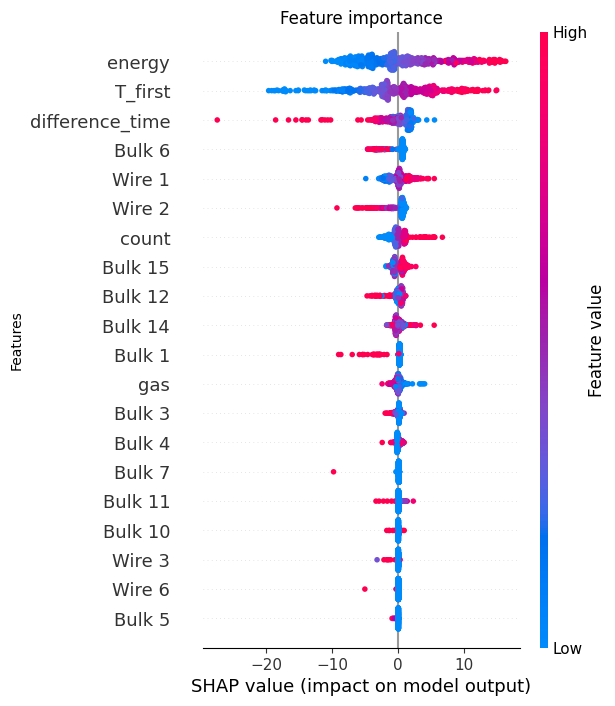

In [159]:
shap.summary_plot(shap_values, features=X_test, feature_names=X.columns, plot_size=(6,7), show=False)
plt.title('Feature importance'); plt.ylabel('Features'); plt.show()

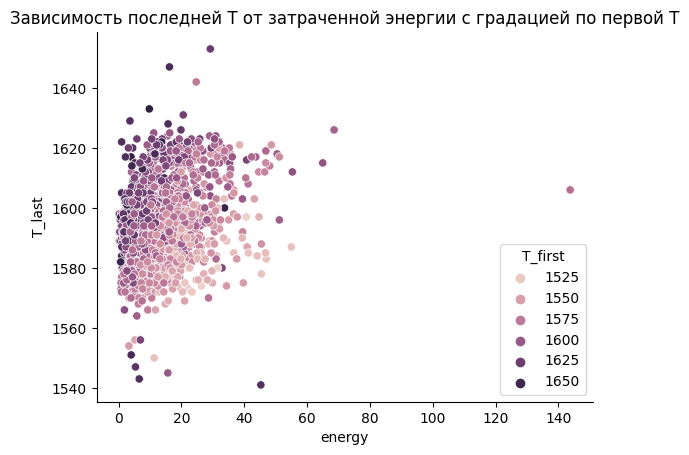

In [160]:
sns.scatterplot(data=data, x='energy', y='T_last', hue='T_first')
plt.title('Зависимость последней Т от затраченной энергии с градацией по первой Т'); sns.despine()

Комментарий ниже в выводе.

## Conclusion

Прогнозирование конечной температуры расплава в печь-ковше возможно со средней абсолютной ошибкой 5.547 °С.\
Применение ML для прогнозирования температуры расплава целесообразно.

Проведён исследовательский анализ данных. Вывод в разделе [1.11 Conclusion by EDA](#Conclusion_by_EDA).

Построен ряд ML моделей, подобраны гиперпараметры и архитектура. Результат на валидационной выборке:\
\- RandomForestRegressor: MAE = 6.057\
\- CatBoost: MAE = 5.702\
\- Neural network: MAE = 6.160.\
Вывод в разделе [2.5  Conclusion by ML](#Conclusion_by_ML).

На тестовой выборке выбранная лучшая модель на базе нейронной сети показала результат:\
\- MAE = 5.547;\
\- R2 = 0.497.

Константная медианная модель дала результат:\
\- MAE = 7.814;\
\- R2 = -0.006.\
Таким образом, построенная модель показала результат в 1,4 раз лучше чем константная.

Топ признаков влияющих на последнюю температуру:
общая затраченная энергия (учитывается активная мощность), первая температура партии, продолжительность партии, объём поданного сыпучего материала №6, и объём проволочного материала №1.

Визуализация зависимости между целевым признаком (T_last) и самым влияющим (energy) показала: более высокие значения затраченной энергии соответсвуют более высокой последней температуре в партии.\
Также у партий с высокими затратами энергии начальная температура была более низкой.